## HeartDieseasePred


Heart disease is the number one cause of death worldwide, so if you're looking to use data science for good you've come to the right place. To learn how to prevent heart disease we must first learn to reliably detect it.
The dataset is from a study of heart disease that has been open to the public for many years. The study collects various measurements on patient health and cardiovascular statistics, and of course makes patient identities anonymous.


About:

Preventing heart disease is important. Good data-driven systems for predicting heart disease can improve the entire research and prevention process, making sure that more people can live healthy lives.
In the United States, the Centers for Disease Control and Prevention is a good resource for information about heart disease. According to their website:
- About 610,000 people die of heart disease in the United States every year–that’s 1 in every 4 deaths.
- Heart disease is the leading cause of death for both men and women. More than half of the deaths due to heart disease in 2009 were in men.
- Coronary heart disease (CHD) is the most common type of heart disease, killing over 370,000 people annually.
- Every year about 735,000 Americans have a heart attack. Of these, 525,000 are a first heart attack and 210,000 happen in people who have already had a heart attack.
- Heart disease is the leading cause of death for people of most ethnicities in the United States, including African Americans, Hispanics, and whites. For American Indians or Alaska Natives and Asians or Pacific Islanders, heart disease is second only to cancer.


**Problem description**

The goal is to predict the binary class heart_disease_present, which represents whether or not a patient has heart disease:
- 0 represents no heart disease present
- 1 represents heart disease present

Dataset is from https://www.drivendata.org/competitions/54/machine-learning-with-a-heart/page/109/
#=================================================================================================#

## <font color='orange'>1. Import libraries</font>

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# -----------------------------------------------------
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import sklearn
#!pip install chart_studio
from chart_studio import plotly

# -----------------------------------------------------
from sklearn import preprocessing
from sklearn.preprocessing import (StandardScaler, 
                                   MinMaxScaler, 
                                   PowerTransformer)
# -----------------------------------------------------
from sklearn import metrics
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.metrics import (recall_score, 
                             precision_score, 
                             roc_curve, auc)
# -----------------------------------------------------
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

# -----------------------------------------------------
from sklearn.ensemble import (RandomForestClassifier, 
                              AdaBoostClassifier,
                              StackingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# -----------------------------------------------------
from sklearn import model_selection
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     RepeatedStratifiedKFold, StratifiedKFold,
                                     GridSearchCV, RandomizedSearchCV, KFold)

# -----------------------------------------------------
#!pip install mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

# -----------------------------------------------------
#!pip install tabulate
from tabulate import tabulate

# -----------------------------------------------------
from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [3]:
start_time0 = dt.datetime.now()
print("Started at ", start_time0)

Started at  2021-08-09 09:12:15.616243


### Define functions

In [4]:
### Plot function

def count_plot(df, feature, ax):
    """
    This function takes three positional argument for count plot.
    A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable
    
    df - dataframe, feature - single feature, ax -  matplotlib Axes; Axes object to draw the plot onto
    """
    
    a = sns.countplot(x=feature, data=df, order=df[feature].value_counts().index, 
                       ax=ax) # .set_title('Cap Shape Distribution  palette="YlOrRd",

    for p in a.patches:
        a.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', 
                       color='black', size=12)

#----------------------------------------------------------------------------------------------------------

def count_plot_with_hue(df, feature, hueLabel, ax):
    """
    This function takes three positional argument for count plot.
    A count plot can be thought of as a histogram across a categorical, instead of quantitative, variable
    
    df - dataframe, feature - single feature, 
    hueLabel - shade by classification label
    ax -  matplotlib Axes; Returns the Axes object with the plot drawn onto it
    """
    
    b = sns.countplot(x = feature, data = df, hue = hueLabel, 
                      order = df[feature].value_counts().index, 
                      ax = ax) # .set_ylabel('count')  palette="YlGn",#palette=('#addd8e','#f7fcb9'), 

    for p in b.patches:
        b.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha = 'center', va = 'bottom', 
                        color = 'black', size = 10)

#------------------------------------------------------------------------------------------------------------------

def predict_with_best_t(proba, threshold):
    ''' This function makes predictions against the best threshold value''' 
    predictions = []
    for i in proba:
        if i >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#------------------------------------------------------------------------------------------------------------------

def best_threshold(thresholds, fpr, tpr):
    ''' this function finds the best threshold '''
    
    # calculate the g-mean for each threshold
    # gmeans = sqrt(tpr * (1-fpr))
    
    # locate the index of the largest tpr * (1-fpr) to determine the threshold value to use
    ix = thresholds[np.argmax(tpr*(1 - fpr))]
    
    print("The max value of tpr*(1 - fpr) is", np.round(max(tpr*(1 - fpr)), 3), "for threshold", np.round(ix,3))
    return ix


## <font color='orange'>2. Load the data</font>

In [5]:
df_features = pd.read_csv("values.csv")
df_labels = pd.read_csv("labels.csv")

In [6]:
df_features.head()

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0


In [7]:
df_labels.head()

,patient_id,heart_disease_present
0,0z64un,0
1,ryoo3j,0
2,yt1s1x,1
3,l2xjde,1
4,oyt4ek,0


In [8]:
print(df_features.shape)  # (19237, 18)
print("="*50)
print("Columns from data:- \n", df_features.columns)

(180, 14)
Columns from data:- 
 Index(['patient_id', 'slope_of_peak_exercise_st_segment', 'thal',
       'resting_blood_pressure', 'chest_pain_type', 'num_major_vessels',
       'fasting_blood_sugar_gt_120_mg_per_dl', 'resting_ekg_results',
       'serum_cholesterol_mg_per_dl', 'oldpeak_eq_st_depression', 'sex', 'age',
       'max_heart_rate_achieved', 'exercise_induced_angina'],
      dtype='object')


In [9]:
print(df_labels.shape)  # (19237, 18)
print("="*50)
print("Columns from data:- \n", df_labels.columns)

(180, 2)
Columns from data:- 
 Index(['patient_id', 'heart_disease_present'], dtype='object')


#===================================================================================================#

## <font color='orange'>3. Data quality check</font>

### 3.1 Check for duplicate data

In [10]:
# duplicated - Return boolean Series denoting duplicate rows, optionally only considering certain columns
df_features[df_features.duplicated(keep = 'last')].count()

patient_id                              0
slope_of_peak_exercise_st_segment       0
thal                                    0
resting_blood_pressure                  0
chest_pain_type                         0
num_major_vessels                       0
fasting_blood_sugar_gt_120_mg_per_dl    0
resting_ekg_results                     0
serum_cholesterol_mg_per_dl             0
oldpeak_eq_st_depression                0
sex                                     0
age                                     0
max_heart_rate_achieved                 0
exercise_induced_angina                 0
dtype: int64

- No duplicate data is present

### 3.2 Check for missing values

In [11]:
missing_value = (df_features.isnull() | df_features.isna() | df_features.eq(' ') | df_features.eq('')).sum()
print("Train Data\n ", missing_value[missing_value>0])

Train Data
  Series([], dtype: int64)


- No missing data

### 3.3 Compare and check for missing patient id

In [12]:
comparison_column = np.where(df_features["patient_id"] != df_labels["patient_id"], True, False)
df_labels[comparison_column]

,patient_id,heart_disease_present


- There are no patient_id that are present in df_features dataframe but are missing from df_labels and vice versa

#===================================================================================================#

## <font color='orange'>4. Descriptive Statistics</font>

In [13]:
# join the df_features and df_values for analysis
df_merged_data = df_features.merge(df_labels, on=['patient_id'], how='left')
#pd.merge([df_features, df_labels], )
df_merged_data.head(3)

,patient_id,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina,heart_disease_present
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1


In [14]:
df_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 15 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   patient_id                            180 non-null    object 
 1   slope_of_peak_exercise_st_segment     180 non-null    int64  
 2   thal                                  180 non-null    object 
 3   resting_blood_pressure                180 non-null    int64  
 4   chest_pain_type                       180 non-null    int64  
 5   num_major_vessels                     180 non-null    int64  
 6   fasting_blood_sugar_gt_120_mg_per_dl  180 non-null    int64  
 7   resting_ekg_results                   180 non-null    int64  
 8   serum_cholesterol_mg_per_dl           180 non-null    int64  
 9   oldpeak_eq_st_depression              180 non-null    float64
 10  sex                                   180 non-null    int64  
 11  age                

**Data type summary**

- 12 integers (int64)
- 1 floating (float64)
- 2 objects (object)

### 4.1 Rename the column names

In [15]:
### Rename the column names to reduce name size of few columns

col_dict = {'slope_of_peak_exercise_st_segment': 'ST_seg_pe_slope', 
            'resting_blood_pressure':'resting_bp',
            'fasting_blood_sugar_gt_120_mg_per_dl': 'fbs_gt_120',
            'serum_cholesterol_mg_per_dl': 'serum_chol',
            'oldpeak_eq_st_depression':'oldpeak_ST_dep',
            'max_heart_rate_achieved':'max_hr_ach',
            'exercise_induced_angina':'exer_angina',
            'heart_disease_present': "has_HeartDisease"}   ## key→old name, value→new name

df_merged_data.columns = [col_dict.get(x, x) for x in df_merged_data.columns]

In [16]:
data_describe = df_merged_data.loc[:, ~df_merged_data.columns.isin(['patient_id'])].describe().T.applymap('{:.2f}'.format) 

data_describe

,count,mean,std,min,25%,50%,75%,max
ST_seg_pe_slope,180.00,1.55,0.62,1.00,1.00,1.00,2.00,3.00
resting_bp,180.00,131.31,17.01,94.00,120.00,130.00,140.00,180.00
chest_pain_type,180.00,3.16,0.94,1.00,3.00,3.00,4.00,4.00
num_major_vessels,180.00,0.69,0.97,0.00,0.00,0.00,1.00,3.00
fbs_gt_120,180.00,0.16,0.37,0.00,0.00,0.00,0.00,1.00
resting_ekg_results,180.00,1.05,1.00,0.00,0.00,2.00,2.00,2.00
serum_chol,180.00,249.21,52.72,126.00,213.75,245.50,281.25,564.00
oldpeak_ST_dep,180.00,1.01,1.12,0.00,0.00,0.80,1.60,6.20
sex,180.00,0.69,0.46,0.00,0.00,1.00,1.00,1.00
age,180.00,54.81,9.33,29.00,48.00,55.00,62.00,77.00


**Observation**

Following features have 0 as minimum values
- num_major_vessels, fbs_gt_120, resting_ekg_results, oldpeak_ST_dep, exer_angina

Lets invetigate whats going on. Should these features be treated as categorical instead of numeric? I will use value_count function to check the unique values these columns contain and take decision accordingly.

In [17]:
# Lets explore these feature with 0 values
df_merged_data['exer_angina'].value_counts()

0    123
1     57
Name: exer_angina, dtype: int64

Based on column description and number of unique values these column contains following columns will be treated as categorical
- 'num_major_vessels', 
- 'fbs_gt_120', 
- 'resting_ekg_results', 
- 'exer_angina',
- 'chest_pain_type',
- 'sex'

### 4.2 Convert the datatype of following feature from int64 to object

In [18]:
# column list to convert from int64 to object type
col_list = ['num_major_vessels', 'fbs_gt_120', 'resting_ekg_results', 
            'exer_angina','chest_pain_type','sex']

for c in df_merged_data[col_list].columns:
    if df_merged_data[c].dtype == 'int64':
        try:
            df_merged_data[c] = df_merged_data[c].astype(str).astype('object')
        except:
            print('Column',' ',c,' cannot be converted to object.')

In [19]:
df_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient_id           180 non-null    object 
 1   ST_seg_pe_slope      180 non-null    int64  
 2   thal                 180 non-null    object 
 3   resting_bp           180 non-null    int64  
 4   chest_pain_type      180 non-null    object 
 5   num_major_vessels    180 non-null    object 
 6   fbs_gt_120           180 non-null    object 
 7   resting_ekg_results  180 non-null    object 
 8   serum_chol           180 non-null    int64  
 9   oldpeak_ST_dep       180 non-null    float64
 10  sex                  180 non-null    object 
 11  age                  180 non-null    int64  
 12  max_hr_ach           180 non-null    int64  
 13  exer_angina          180 non-null    object 
 14  has_HeartDisease     180 non-null    int64  
dtypes: float64(1), int64(6), object(8)
memor

#### 4.2.1 Data type summary

- 6 integers (int64)
- 1 floating (float64)
- 8 objects (object)

In [20]:
df_merged_data.loc[:, ~df_merged_data.columns.isin(['patient_id'])].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ST_seg_pe_slope,180.0,NaN,NaN,NaN,1.55,0.618838,1.0,1.0,1.0,2.0,3.0
thal,180,3,normal,98,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resting_bp,180.0,NaN,NaN,NaN,131.311111,17.010443,94.0,120.0,130.0,140.0,180.0
chest_pain_type,180,4,4,82,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_major_vessels,180,4,0,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fbs_gt_120,180,2,0,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
resting_ekg_results,180,3,2,94,NaN,NaN,NaN,NaN,NaN,NaN,NaN
serum_chol,180.0,NaN,NaN,NaN,249.211111,52.717969,126.0,213.75,245.5,281.25,564.0
oldpeak_ST_dep,180.0,NaN,NaN,NaN,1.01,1.121357,0.0,0.0,0.8,1.6,6.2
sex,180,2,1,124,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
skew_kurt_features_ = pd.DataFrame(columns = ['skewness','kurtosis'])
skew_kurt_features_['skewness'] = df_merged_data.skew() #df_bc_transformed.apply(lambda x: skew(x)).sort_values(ascending=False),
skew_kurt_features_['kurtosis'] = df_merged_data.kurtosis() #df_bc_transformed.apply(lambda x: stats.kurtosis(x)).sort_values(ascending=False)

### 4.3 Data Summary report

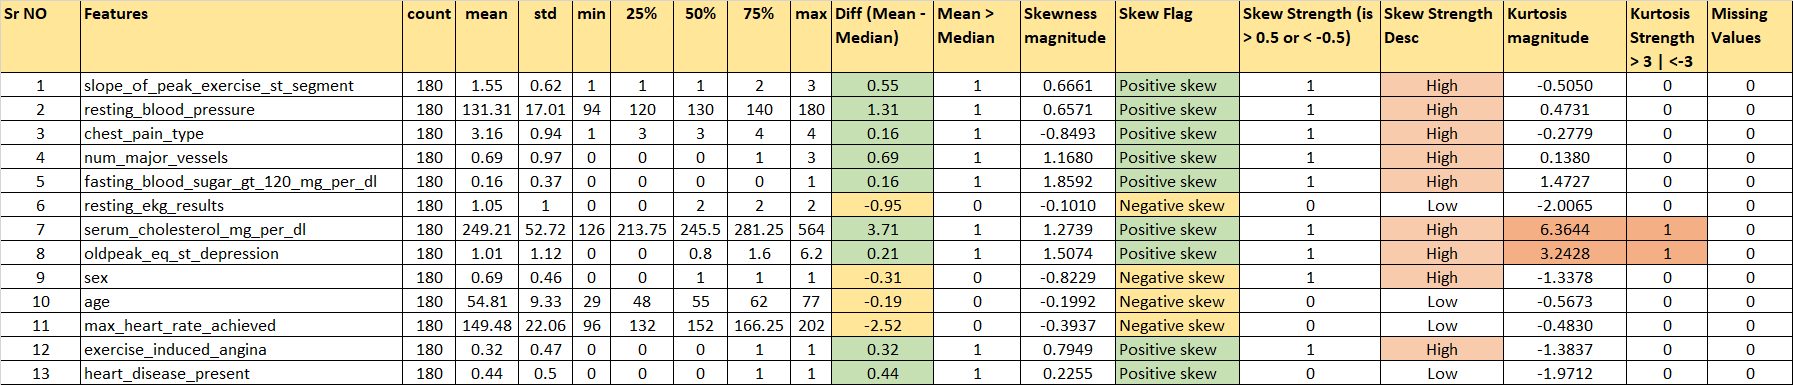

#### Legend
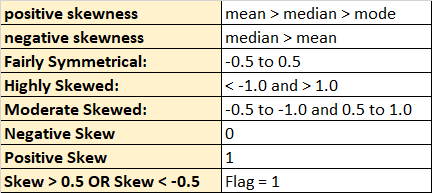

#### Finding - Skew

**High skew (> 1)**
- four features: ['fasting_blood_sugar_gt_120_mg_per_dl','oldpeak_eq_st_depression','serum_cholesterol_mg_per_dl',
 'num_major_vessels']	
- Explore and check if applying applying log transformation reduces the skew

**Moderate skew (> 0.5 and < 1)**
- three features: ['exercise_induced_angina',	'slope_of_peak_exercise_st_segment','resting_blood_pressure']
- Explore and check if applying square-root transformation reduces the skew

**Positive Skew (Mean > Median)**
- eight features: ['fasting_blood_sugar_gt_120_mg_per_dl',	'oldpeak_eq_st_depression',	'serum_cholesterol_mg_per_dl',	'num_major_vessels',	'exercise_induced_angina',	'slope_of_peak_exercise_st_segment',	'resting_blood_pressure',	'heart_disease_present']

**Negative Skew (Median > Mean)**
- three features: ['resting_ekg_results',	'age',	'max_heart_rate_achieved']

#### Finding - Kurtosis ( > 3)
- two features: ['serum_cholesterol_mg_per_dl','oldpeak_eq_st_depression']
- **Note:** Kurtosis is a statistical measure, whether the data is heavy-tailed or light-tailed in a normal distribution. A negative kurtosis means that your distribution is flatter than a normal curve with the same mean and standard deviation. Kurtosis refers to the degree of presence of outliers in the distribution. It also describes the peakedness of the distribution
- Identifying and treating outlier should reduce the kurtosis 


## <font color='orange'>5. Exploratory Data Analysis</font>

In [22]:
df_merged_data.head()

,patient_id,ST_seg_pe_slope,thal,resting_bp,chest_pain_type,num_major_vessels,fbs_gt_120,resting_ekg_results,serum_chol,oldpeak_ST_dep,sex,age,max_hr_ach,exer_angina,has_HeartDisease
0,0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
1,ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
2,yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
3,l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
4,oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


### 5.1 Subset data into numeric and categorical features

In [23]:
# subset columns with numerical data types
num_ix = df_merged_data.select_dtypes(include = ['int32','int64', 'float64']).columns #int32
num_attri = df_merged_data[num_ix]

#### Another approach
# Get only the Numeric Variables (Columns with numeric values in it)
# df_new_data._get_numeric_data().columns

# subset columns with object data types
cat_ix = df_merged_data.select_dtypes(include = ['object']).columns
cat_attri = df_merged_data[cat_ix].loc[:, ~df_merged_data[cat_ix].columns.isin(['patient_id'])]

### 5.2 Target column - has_HeartDisease

- heart_disease_present = 1 means "Has Heart Disease"
- heart_disease_present = 0 means "No Heart Disease"

In [24]:
plt.rcParams["axes.labelsize"] = 15

0    100
1     80
Name: has_HeartDisease, dtype: int64


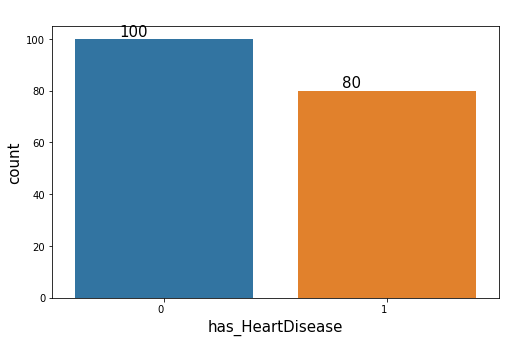

In [25]:
#Count the values of target variables
plt.figure(figsize=(8,5))
print(df_merged_data.has_HeartDisease.value_counts()) #By defeault value_counts will sort with the highest value first
chart = sns.countplot(x='has_HeartDisease', data=df_merged_data)

chart.set_xticklabels(chart.get_xticklabels(),  horizontalalignment='right') #rotation=45,

for p in chart.patches:
    chart.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', color='black', size=15)

plt.show()

>In this dataset 44% of patients have heart disease

## 5.3 Analysis of Categorical Features

### 5.3.1 Plot - unique values categorical features

Grouped bar chart is used as the visual representation of Chi-Square Analysis

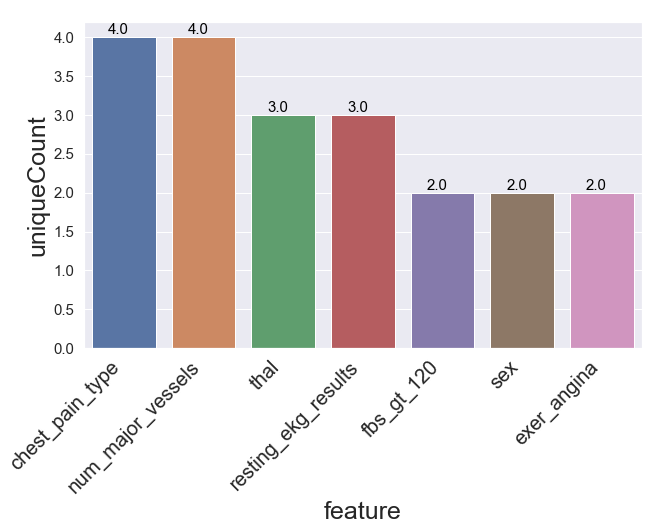

In [26]:
col_val_cnt = cat_attri.nunique(axis=0).reset_index()#.sort_values(ascending=False)
col_val_cnt.columns = ['feature','uniqueCount']

sns.set(rc={'axes.labelsize':25,
            'xtick.labelsize':15,
            'ytick.labelsize':15})

#sns.set(font_scale=1.4)
fig = plt.figure(figsize=(10,6))
ax = sns.barplot(x='feature', y='uniqueCount', data=col_val_cnt.sort_values('uniqueCount', ascending=False))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', size=20) 

for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='left', va='bottom', 
                   color='black', size=15)

- All the categorical features have few unique values. Later I will apply one hot encoding for further analysis

In [27]:
cat_attri.columns

Index(['thal', 'chest_pain_type', 'num_major_vessels', 'fbs_gt_120',
       'resting_ekg_results', 'sex', 'exer_angina'],
      dtype='object')

### 5.3.2 thal

The relationship between two categorical variables can be visualized using grouped bar charts

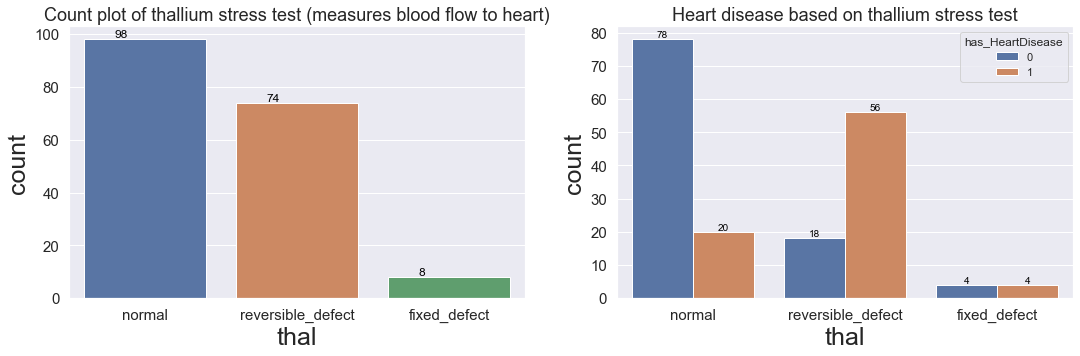

In [28]:
fig, axarr = plt.subplots(1, 2, figsize=(18,5))

axarr[0].set_title('Count plot of thallium stress test (measures blood flow to heart)', fontsize= 18)

count_plot(df_merged_data, 'thal', axarr[0])

#----------------------------------------------------------------------------------------------------------
axarr[1].set_title('Heart disease based on thallium stress test', fontsize= 18)

count_plot_with_hue(df_merged_data, 'thal', 'has_HeartDisease', axarr[1])

- 75% of participants with improper blood movement while exercising (reversible defect) have higher heart disease. Also there are 25% participants who have improper blood movement while exercising but do not have heart disease
**Surprising**
- 20% of participants who, as per thallium stress test, have proper blood movement while exercising have heart disease
- 50% of participants who had improper blood movement while exercising but now fix too have heart disease

**Observation**
- Thallium stress test (measures blood flow to heart) do not seem to be too effective in detecting heart disease

### 5.3.3 Chest pain type

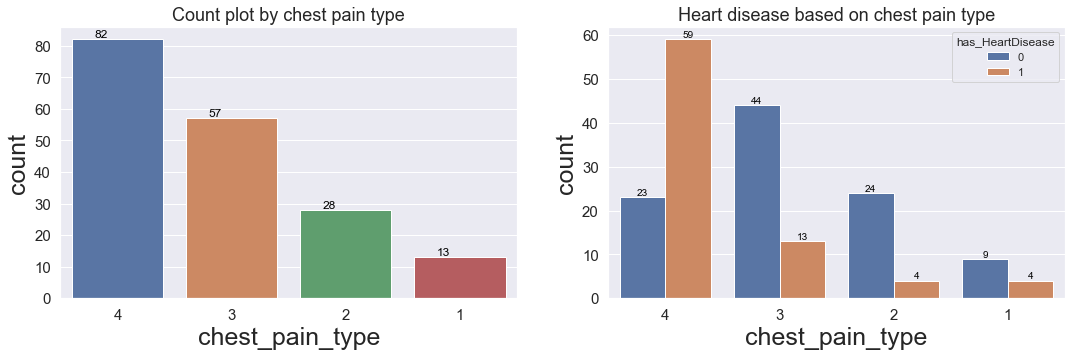

In [29]:
fig, axarr = plt.subplots(1, 2, figsize=(18,5))

axarr[0].set_title('Count plot by chest pain type', fontsize= 18)

count_plot(df_merged_data, 'chest_pain_type', axarr[0])

#----------------------------------------------------------------------------------------------------------
axarr[1].set_title('Heart disease based on chest pain type', fontsize= 18)

count_plot_with_hue(df_merged_data, 'chest_pain_type', 'has_HeartDisease', axarr[1])

- Only 30% of people with chest pain due to angina (type 1) have heart disease. Expectation was that this number should be more compared to other chest pain type because Angina is a condition marked by severe pain in the chest due to an inadequate blood supply to the heart
- 72% of people with no chest pain (Type 4 - Asymptomatic) have heart disease
- 23% with Non-anginal pain (Type 3) have heart disease
- 14% with Atypical angina (Type 2) have heart disease 

### 5.3.4 Number of major vessels

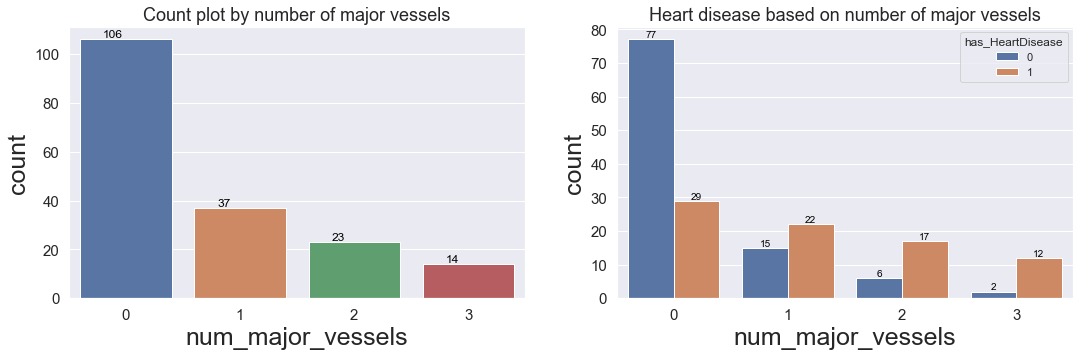

In [30]:
fig, axarr = plt.subplots(1, 2, figsize=(18,5))

axarr[0].set_title('Count plot by number of major vessels', fontsize= 18)

count_plot(df_merged_data, 'num_major_vessels', axarr[0])

#----------------------------------------------------------------------------------------------------------
axarr[1].set_title('Heart disease based on number of major vessels', fontsize= 18)
 
count_plot_with_hue(df_merged_data, 'num_major_vessels', 'has_HeartDisease', axarr[1])

- It seems heart disease rate increases with increase in number of major vessel. Three major vessel is highest heart disease
- 78% of heart disease has one major vessel
- 74% of heart disease has two major vessel
- 86% of heart disease has three major vessel

### 5.3.5 Blood sugar level during fasting

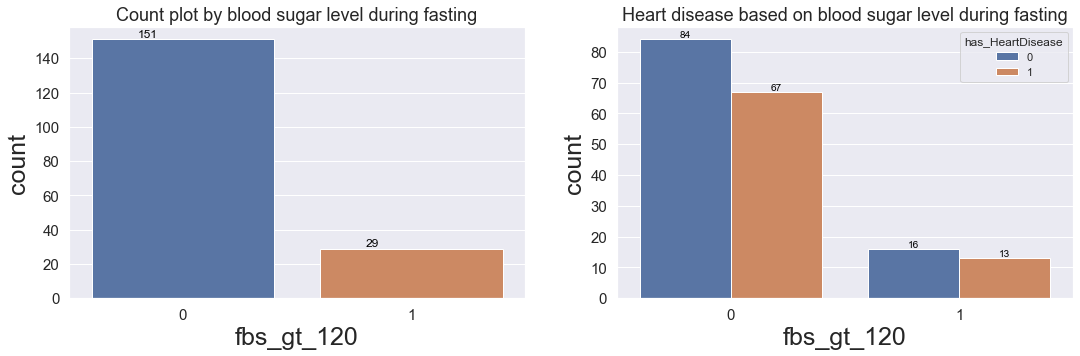

In [31]:
fig, axarr = plt.subplots(1, 2, figsize=(18,5))

axarr[0].set_title('Count plot by blood sugar level during fasting', fontsize= 18)

count_plot(df_merged_data, 'fbs_gt_120', axarr[0])

#----------------------------------------------------------------------------------------------------------
axarr[1].set_title('Heart disease based on blood sugar level during fasting', fontsize= 18)
 
count_plot_with_hue(df_merged_data, 'fbs_gt_120', 'has_HeartDisease', axarr[1])

- 38% with fasting blood sugar level less then 120 mg/dl has heart disease
- 45% with fasting blood sugar level greater then 120 mg/dl has heart disease
- With a very little  difference of 7% it do not seem that fasting blood sugar level is good indicator of heart disease

### 5.3.6 Resting electrocardiographic results

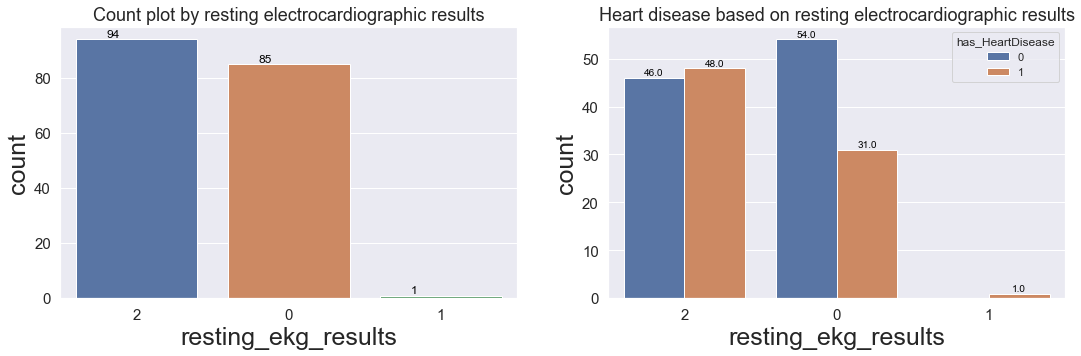

In [32]:
fig, axarr = plt.subplots(1, 2, figsize=(18,5))

axarr[0].set_title('Count plot by resting electrocardiographic results', fontsize= 18)

count_plot(df_merged_data, 'resting_ekg_results', axarr[0])

#----------------------------------------------------------------------------------------------------------
axarr[1].set_title('Heart disease based on resting electrocardiographic results', fontsize= 18)
 
count_plot_with_hue(df_merged_data, 'resting_ekg_results', 'has_HeartDisease', axarr[1])

- 51% with resting electrocardiographic results as Type 2, left ventricular hypertrophy (Enlarged heart's main pumping chamber) have heart disease. I would have expected this number to be more but this do not seem to be the case
- 37% with no resting electrocardiographic results (Type 0) have heart disease
- 100% with resting electrocardiographic results as non-normal heart beat (Type 1) have heart disease. This can be one of the indicator which should be checked frequently to identify the heart disease

### 5.3.7 Sex

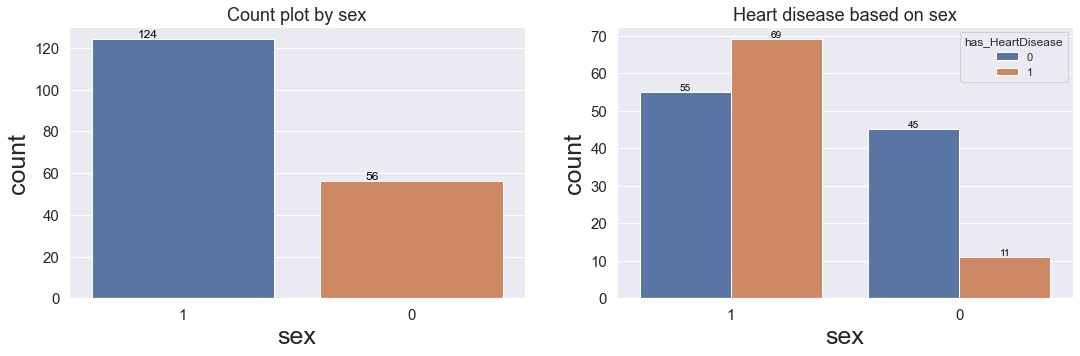

In [33]:
fig, axarr = plt.subplots(1, 2, figsize=(18,5))

axarr[0].set_title('Count plot by sex', fontsize= 18)

count_plot(df_merged_data, 'sex', axarr[0])

#----------------------------------------------------------------------------------------------------------
axarr[1].set_title('Heart disease based on sex', fontsize= 18)
 
count_plot_with_hue(df_merged_data, 'sex', 'has_HeartDisease', axarr[1])

- 57% of males have heart disease while 20% of female have heart disease. Males seems to suffuer more from heart disease

### 5.3.8 Exercise induced angina

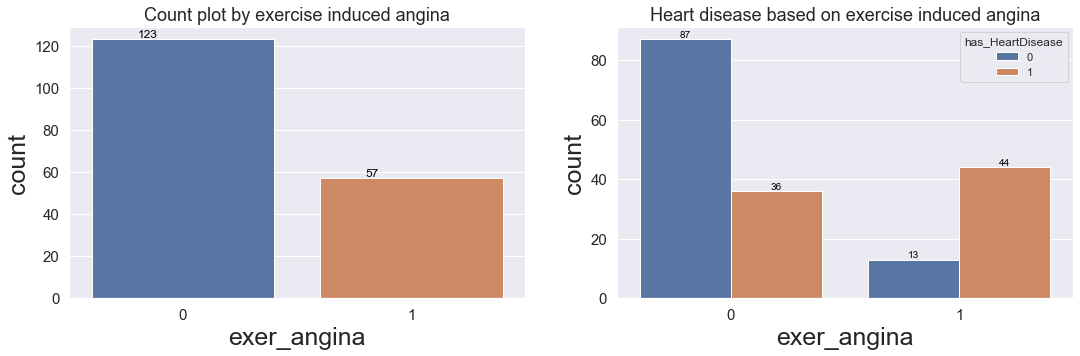

In [34]:
fig, axarr = plt.subplots(1, 2, figsize=(18,5))

axarr[0].set_title('Count plot by exercise induced angina', fontsize= 18)

count_plot(df_merged_data, 'exer_angina', axarr[0])

#----------------------------------------------------------------------------------------------------------
axarr[1].set_title('Heart disease based on exercise induced angina', fontsize= 18)
 
count_plot_with_hue(df_merged_data, 'exer_angina', 'has_HeartDisease', axarr[1])

- 63% have heart disease inspite of no exercise-induced chest pain. There could be other reason for this
- 77% have heart disease due exercise-induced chest pain

### 5.3.9 Lets check variable interaction

#### 5.3.9.1 Age and Chest Pain type

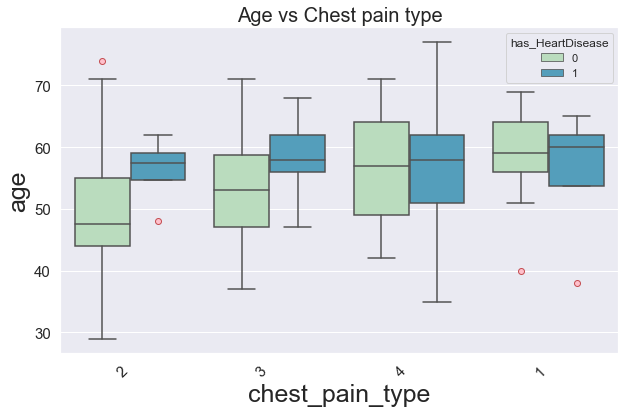

In [35]:
# Box plot between work-class and age for different sex

plt.figure(figsize=(10,6))

flierprops = dict(marker='o', markerfacecolor='pink', markersize=6,
                  linestyle='none', markeredgecolor='r')

chart = sns.boxplot(x = "chest_pain_type",y = "age", hue = "has_HeartDisease", #color = '#fec44f',
                    flierprops=flierprops, data = df_merged_data, palette = 'GnBu')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45, horizontalalignment ='right') 
chart.set_title('Age vs Chest pain type',fontsize=20)
plt.show()

- median age of type 2 (Atypical angina) and type 3 (Non-anginal pain) with heart disease is somewhat higher then without heart disease. Both the median age is approx same. Both seem to be good classifier
- median age of type 1 (Anginal pain) and type 4 with heart disease is approx same then without heart disease

#### 5.3.9.2 Resting Blood Pressure and Chest Pain type

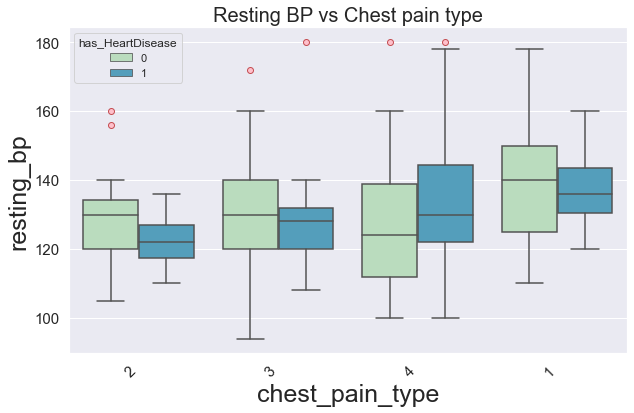

In [36]:
plt.figure(figsize=(10,6))

flierprops = dict(marker='o', markerfacecolor='pink', markersize=6,
                  linestyle='none', markeredgecolor='r')

chart = sns.boxplot(x = "chest_pain_type",y = "resting_bp", hue = "has_HeartDisease", #color = '#fec44f',
                    flierprops=flierprops, data = df_merged_data, palette = 'GnBu')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45, horizontalalignment ='right') 
chart.set_title('Resting BP vs Chest pain type',fontsize=20)
plt.show()

- Median resting BP of type 2 (Atypical angina) with heart disease is low then any other type

#### 5.3.9.3 Sex and Stress of heart during excercise

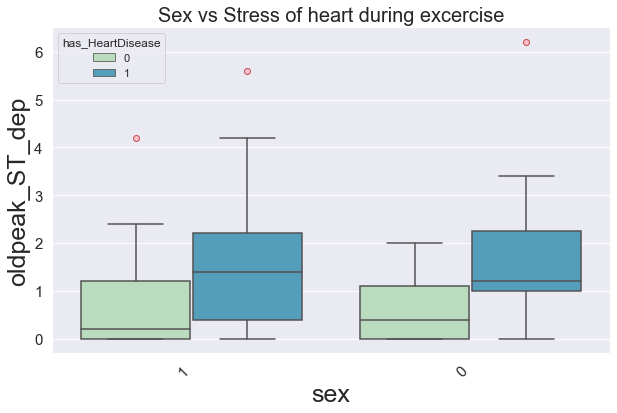

In [37]:
plt.figure(figsize=(10,6))

flierprops = dict(marker='o', markerfacecolor='pink', markersize=6,
                  linestyle='none', markeredgecolor='r')

chart = sns.boxplot(x = "sex",y = "oldpeak_ST_dep", hue = "has_HeartDisease", #color = '#fec44f',
                    flierprops=flierprops, data = df_merged_data, palette = 'GnBu')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45, horizontalalignment ='right') 
chart.set_title('Sex vs Stress of heart during excercise',fontsize=20)
plt.show()

- Median stress for both male and female with heart disease are approx same

#### 5.3.9.4 Fasting blood sugar and Stress of heart during excercise

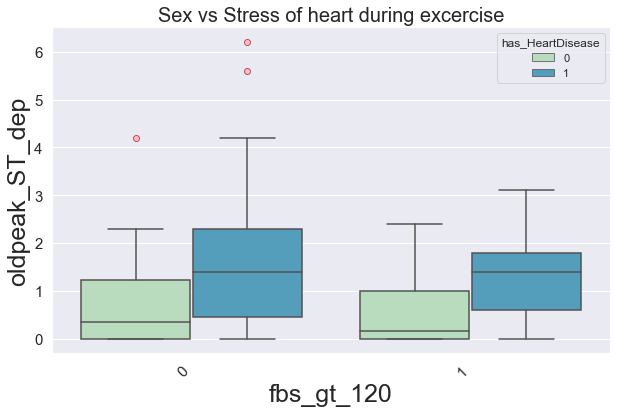

In [38]:
plt.figure(figsize=(10,6))

flierprops = dict(marker='o', markerfacecolor='pink', markersize=6,
                  linestyle='none', markeredgecolor='r')

chart = sns.boxplot(x = "fbs_gt_120",y = "oldpeak_ST_dep", hue = "has_HeartDisease", #color = '#fec44f',
                    flierprops=flierprops, data = df_merged_data, palette = 'GnBu')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45, horizontalalignment ='right') 
chart.set_title('Sex vs Stress of heart during excercise',fontsize=20)
plt.show()

- Median stress for both the level of fasting blood sugar, greater then 120 and less then 120 are approx same

#### 5.3.9.5 Number of major vessels and Stress of heart during excercise

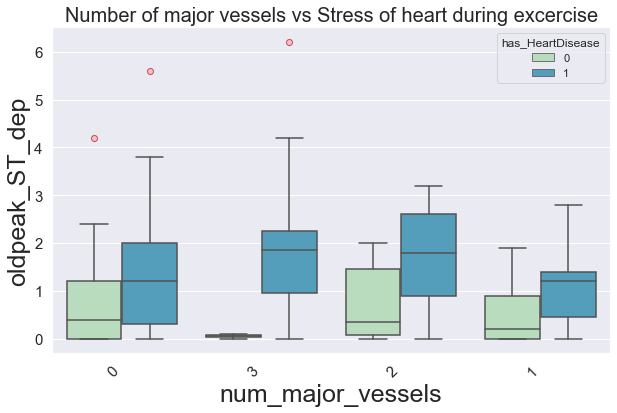

In [39]:
plt.figure(figsize=(10,6))

flierprops = dict(marker='o', markerfacecolor='pink', markersize=6,
                  linestyle='none', markeredgecolor='r')

chart = sns.boxplot(x = "num_major_vessels",y = "oldpeak_ST_dep", hue = "has_HeartDisease", #color = '#fec44f',
                    flierprops=flierprops, data = df_merged_data, palette = 'GnBu')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45, horizontalalignment ='right') 
chart.set_title('Number of major vessels vs Stress of heart during excercise',fontsize=20)
plt.show()

- Median stress with no vessels and one vessle is approx same
- Median stress with three vessels and two vessle is approx same

#### 5.3.9.6 Thallium stress test and Stress of heart during excercise

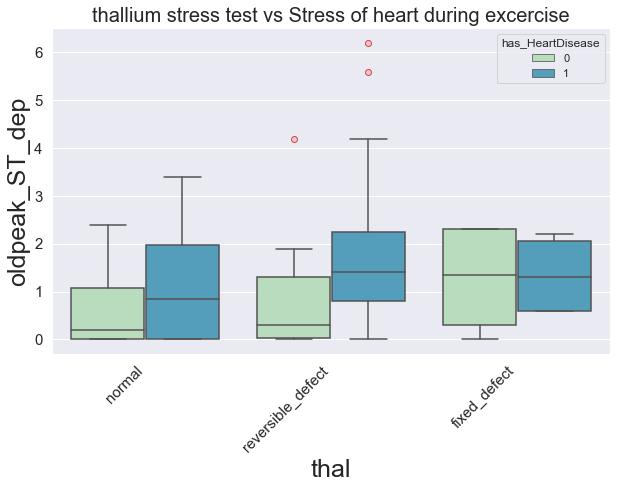

In [40]:
plt.figure(figsize=(10,6))

flierprops = dict(marker='o', markerfacecolor='pink', markersize=6,
                  linestyle='none', markeredgecolor='r')

chart = sns.boxplot(x = "thal",y = "oldpeak_ST_dep", hue = "has_HeartDisease", #color = '#fec44f',
                    flierprops=flierprops, data = df_merged_data, palette = 'GnBu')
chart.set_xticklabels(chart.get_xticklabels(), rotation = 45, horizontalalignment ='right') 
chart.set_title('thallium stress test vs Stress of heart during excercise',fontsize=20)
plt.show()

- Median age of normal thal and thal with reversible_defect have similar median age
- Median age of thal with fixed_defect is quite high w.r.t thal with reversible_defect and normal

## 5.4 Analysis of Numeric Features

### 5.4.1 Box plot

Box plot is used as the visual representation of ANOVA analysis. Box plot displays the distributions of groups of numerical data through their quantiles. Each box shows how spread out the data is within group and putting boxes side by side indicates the difference among groups. It is aligned with ANOVA test which also analyze the degree of variance between-group compared to within-group.

Before box plot and violin we need to normalization or standirdization to bring the feature to same scale

The boxes made using sns.boxplot are really just matplotlib.patches.PathPatch objects. These are stored in ax.artists as a list

In [41]:
target = df_merged_data.loc[:,df_merged_data.columns.isin(['has_HeartDisease'])]
feature = df_merged_data[num_ix].loc[:,~df_merged_data[num_ix].columns.isin(['has_HeartDisease'])]

# normalization
data_norm = (feature - feature.min()) / (feature.max() - feature.min())  
data = pd.concat([target, data_norm.iloc[:,0:6]], axis=1)

# Unpivot a DataFrame from wide to long format
data = pd.melt(data,id_vars="has_HeartDisease",   
                        var_name="features",
                        value_name='value')

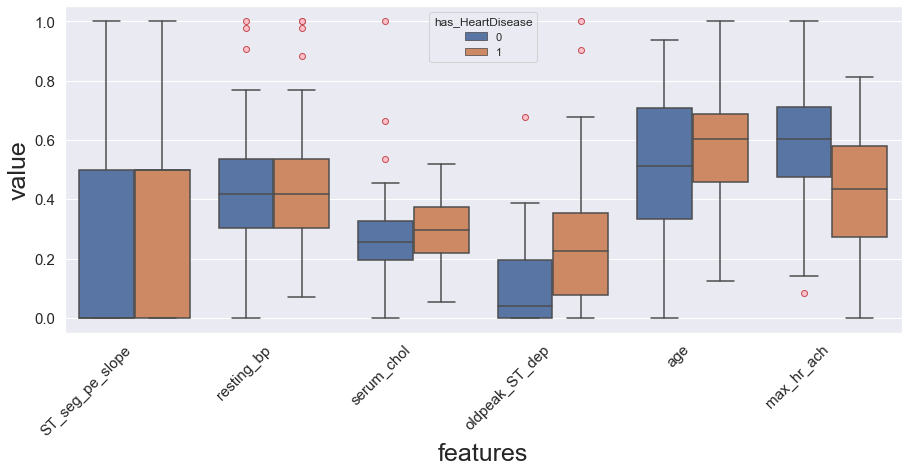

In [42]:
plt.figure(figsize=(15,6))

# plot. Set color of marker edge
flierprops = dict(marker='o', markerfacecolor='pink', markersize=6,
                  linestyle='none', markeredgecolor='r')

chart = sns.boxplot(x="features", y="value", hue="has_HeartDisease",  data = data, flierprops=flierprops)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, fontsize=15, horizontalalignment='right')
plt.yticks(fontsize=15)

plt.show()

- From the box plot above features like max_hr_ach and oldpeak_ST_dep have most classification power
- oldpeak_ST_dep have few outliers too
- Features ST_seg_pe_slope and resting_bp do not have classification power at all and can be ignored for further analysis

#### 5.4.2 Violin plot

As an alternate to box plot violin plot is also equally good to get insight from the data. I will validate the observation from box plot with violin plot too

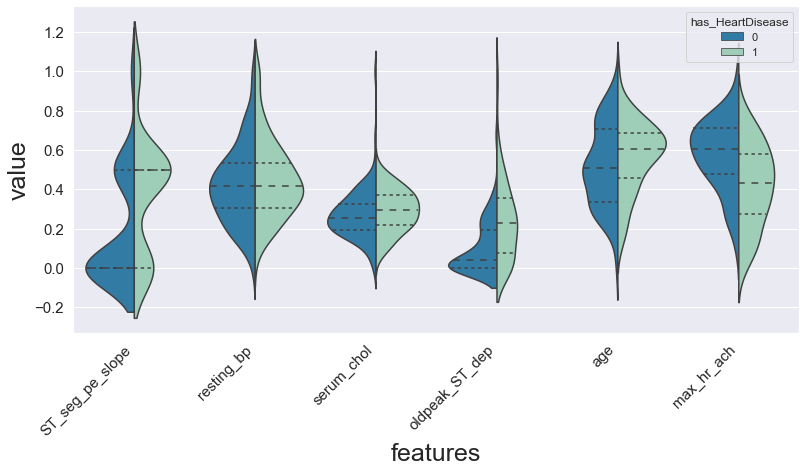

In [43]:
plt.figure(figsize=(13,6))
ax = sns.violinplot(x="features", y="value", hue="has_HeartDisease", data=data,  split=True, 
                    palette = 'YlGnBu_r', inner="quartile") # color = 'YlGn', palette = ['green', 'orange']

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    fontsize=14,
    horizontalalignment='right'
)

plt.xticks(rotation=45,fontsize=15)
plt.yticks(fontsize=15)
plt.show()

- From the violin plot it is more clear that among the two, oldpeak_eq_st_depression have most classification power compared to max_heart_rate_achieved
- serum_cholestrol_mg_per_dl and age have very weak classifying power
- Features slop_of_peak_exercise_st_segment and resting_blood_pressure do not have classification power at all and can be ignored for further analysis

### 5.4.3 Check the correlation

Lets examine the correlation among all the variables. 

Objective: To figure out the highly correlated features and exclude such features from further analysis

Covariances tend to be hard to interpret, so we often use correlation instead. The correlation has the nice property that it is always between -1 and +1, with -1 being a “perfect” negative linear correlation, +1 being a perfect positive linear correlation and 0 indicating that X and Y are uncorrelated. Technically, independence implies zero correlation, but the reverse is not necessarily true

The most common ones are Pearson for linear correlations and Spearman or Kendall tau for nonlinear correlations. 

Regarding categorical to continuous association, there is no such thing as a correlation. You can only measure association

Correlation coefficients can be evaluated by a rudimentary rule of thumb:  
- 0 means no correlation, 
- 0.01-.3 weak, 
- 0.31-0.7 moderate, 
- 0.7-0.9 strong, 
- 0.9-1 very strong

Correlation is affected by outliers

**Correlation between features and target is preferred**

**Correlation between features is suspicious**

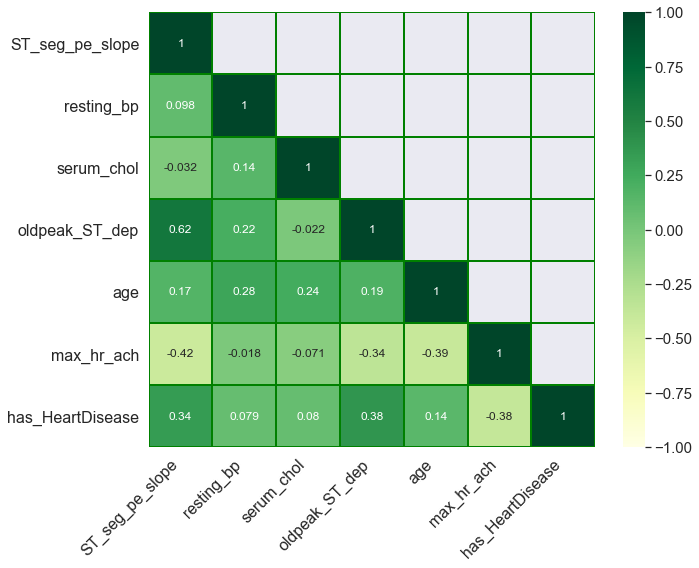

In [44]:
# Let use create a numpy array to use it as our mask
# mask_ut=np.tril(np.ones(corr_df.shape)).astype(np.bool)
# sns.heatmap(corr_df, mask=mask_ut, cmap="Spectral")

# k=1 for to get the upper triangle without the diagonal 
# upper_tri = corr.where(np.tril(np.ones(corr.shape),k=1).astype(np.bool))
corr = df_merged_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape)).astype(np.bool))

# https://matplotlib.org/2.0.2/examples/color/colormaps_reference.html
plt.figure(figsize=(10, 8))
#corr = df_data.corr()

# Draw the heatmap
ax = sns.heatmap(lower_tri, annot=True, fmt='.2g', 
                 vmin=-1, vmax=1, center= 0, 
                 linewidths=1, linecolor='green', 
                 cmap = 'YlGn',annot_kws={"size":12} ) #cmap = 'coolwarm'

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    fontsize=16,
    horizontalalignment='right'
)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)

plt.show()


**Correlation of features with target - has_HeartDisease**
1. correlation strength of numeric features with heart disease is not very high
2. among the available features, the slope of the peak exercise in Stress Test segment(ST_seg_pe_slope) and Stress Test depression induced by exercise(oldpeak_ST_dep) have correlation strength > 0.3 while maximum heart rate achieved have correlation strength < -0.3

**Correlation of features among themselves**
1. the slope of the peak exercise in Stress Test segment(ST_seg_pe_slope) and Stress Test depression induced by exercise(oldpeak_ST_dep) have strong correlation among itself. So, I will prefer to retain Stress Test depression induced by exercise(oldpeak_ST_dep)
2. the slope of the peak exercise in Stress Test segment(ST_seg_pe_slope) and maximum heart rate achieved have negative correlation strength among itself. Both the features have equal correlation strength with target but one is positively correlated while other is negatively correlated

### 5.4.3 Pair Plot

Pair plot or scatterplot is a good complementary to the correlation matrix, especially when nonlinear relationships (e.g. exponential, inverse relationship) might exist. Also the correlation matrix only indicates the strength of linear relationship not the direction of relationship

However both the sns.heatmap() and sns.pairplot() function ignore non-numeric data type

Lets analyze variance and co-variance among the variables

<Figure size 2160x720 with 0 Axes>

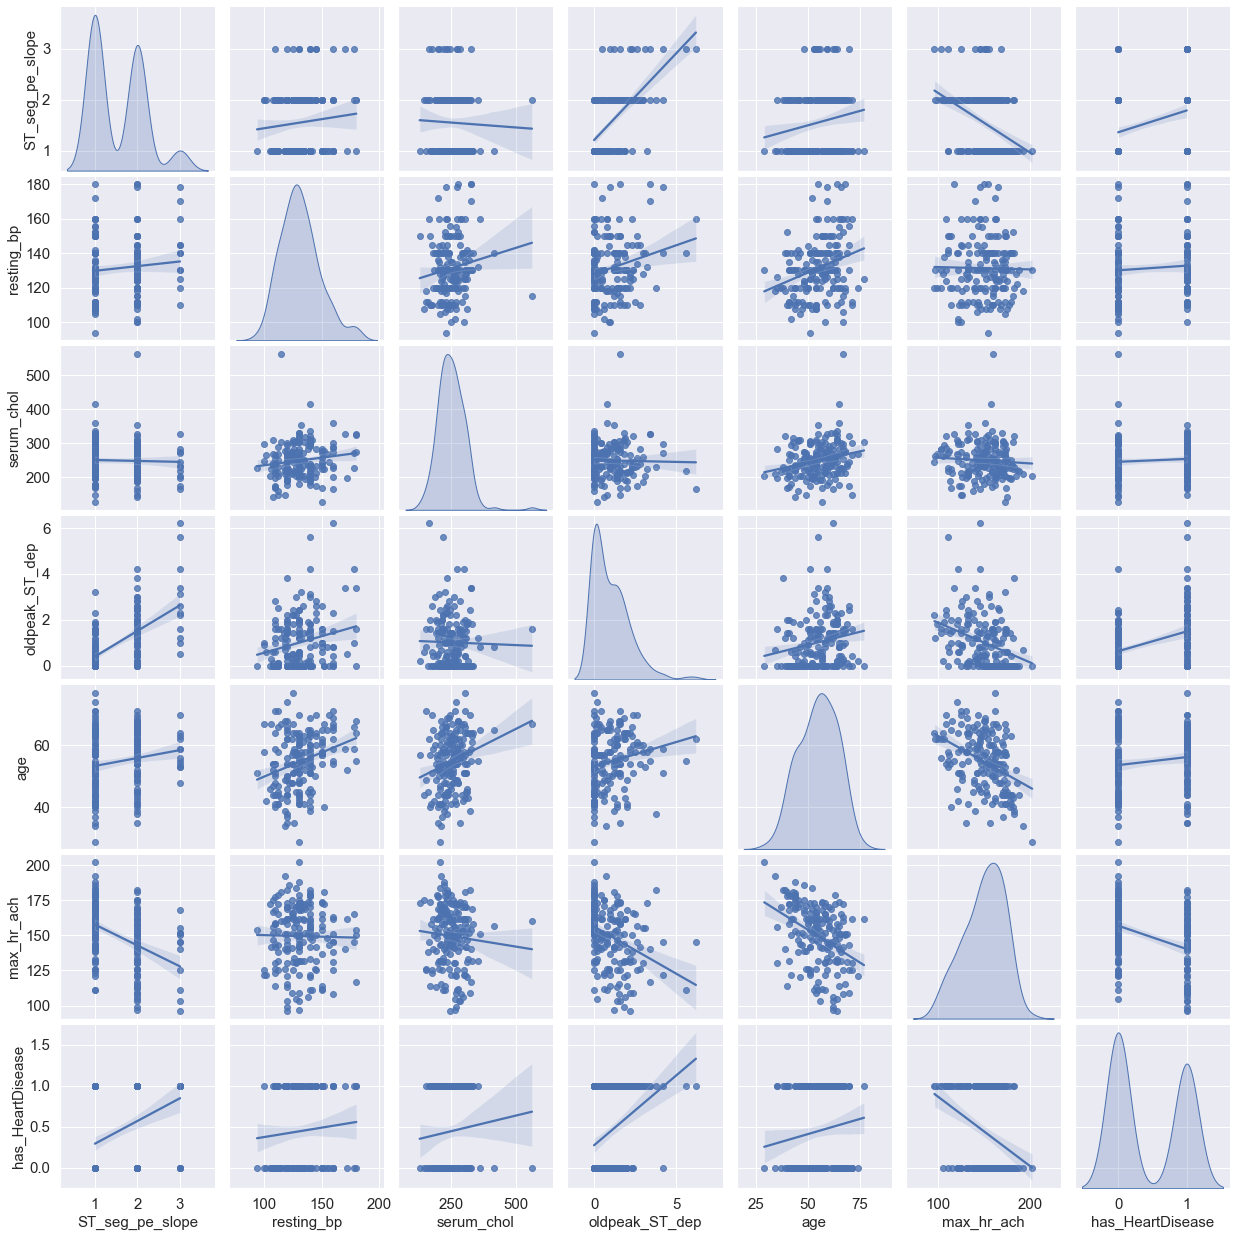

In [45]:
df = df_merged_data#.iloc[:,1:6]

sns.set_context(rc={"axes.labelsize":15, "xtick.labelsize":15, "ytick.labelsize":15})
plt.figure(figsize = (30,10))
sns.pairplot(df, kind='reg', diag_kind = 'kde')
plt.show()

1. the slope of the peak exercise in Stress Test segment(ST_seg_pe_slope) and Stress Test depression induced by exercise(oldpeak_ST_dep) are strongly positively correlated with Heart Disease (has_HeartDisease)
2. maximum heart rate achieved is negatively correlated with Heart Disease (has_HeartDisease)
3. resting blood pressure (resting_bp) and serum cholestoral(serum_chol) seems to have approx normal distribution. However these two variables and age is weakly positively correlated to Heart Disease (has_HeartDisease) 
4. age and maximum heart rate achieved are negatively correlated while age and serum cholestoral(serum_chol) are positively correlated to each other
5. serum cholestoral(serum_chol) is slightly right skewed and seem to be bit pointed
6. age and maximum heart rate seems to have approx normal distribution
7. Stress Test depression induced by exercise(oldpeak_ST_dep) has unimodal right skewed (asymmetric) distributions


From pair plot we do not get strength of the relationship. So I will use heat map to view correlation strength

### 5.4.5 Data distribution - Histogram

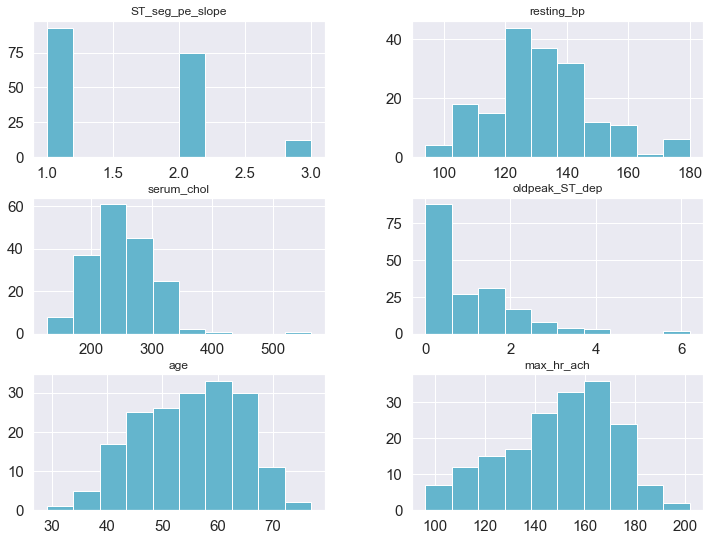

In [46]:
# Make a histogram of the DataFrame
X = df_merged_data[num_ix].drop(['has_HeartDisease'], axis=1)
(X+0.001).hist(figsize=(12, 9), color = 'c');

## <font color='orange'>6. Feature transformation</font>
### 6.1 One Hot encoding

In [47]:
cat_ix

Index(['patient_id', 'thal', 'chest_pain_type', 'num_major_vessels',
       'fbs_gt_120', 'resting_ekg_results', 'sex', 'exer_angina'],
      dtype='object')

In [48]:
# Features with less then 5 unique values will be OHE
col_list = ['thal', 'chest_pain_type', 'num_major_vessels',
            'fbs_gt_120', 'resting_ekg_results', 'sex', 'exer_angina']

df_ohe = pd.get_dummies(df_merged_data[col_list],  drop_first=True)  # 13 new columns were added

In [49]:
df_merged_ohe_data = pd.concat([df_merged_data, df_ohe], axis=1)

In [50]:
df_merged_ohe_data.drop(['patient_id','thal', 'chest_pain_type', 'num_major_vessels',
            'fbs_gt_120', 'resting_ekg_results', 'sex', 'exer_angina'], axis=1, inplace=True)

In [51]:
df_merged_ohe_data.describe().T.applymap('{:.2f}'.format)

,count,mean,std,min,25%,50%,75%,max
ST_seg_pe_slope,180.00,1.55,0.62,1.00,1.00,1.00,2.00,3.00
resting_bp,180.00,131.31,17.01,94.00,120.00,130.00,140.00,180.00
serum_chol,180.00,249.21,52.72,126.00,213.75,245.50,281.25,564.00
oldpeak_ST_dep,180.00,1.01,1.12,0.00,0.00,0.80,1.60,6.20
age,180.00,54.81,9.33,29.00,48.00,55.00,62.00,77.00
max_hr_ach,180.00,149.48,22.06,96.00,132.00,152.00,166.25,202.00
has_HeartDisease,180.00,0.44,0.50,0.00,0.00,0.00,1.00,1.00
thal_normal,180.00,0.54,0.50,0.00,0.00,1.00,1.00,1.00
thal_reversible_defect,180.00,0.41,0.49,0.00,0.00,0.00,1.00,1.00
chest_pain_type_2,180.00,0.16,0.36,0.00,0.00,0.00,0.00,1.00


## <font color='orange'>7. Baseline model</font>

### 7.1 Split the data into train and test

In [52]:
X = df_merged_ohe_data.loc[ : , df_merged_ohe_data.columns != 'has_HeartDisease']
y = df_merged_ohe_data.has_HeartDisease

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [54]:
model_rf = RandomForestClassifier(random_state=2)
model_rf.fit(X_train, y_train)

# Evaluate the model
y_tr_predict = model_rf.predict(X_train)
y_te_predict = model_rf.predict(X_test)

In [55]:
print("Train AUC Score: ", round(accuracy_score(y_train, y_tr_predict),4))
print("Test AUC Score: ", round(accuracy_score(y_test, y_te_predict),4))
#---------------------------------------------------------------------------
# Recall Score (how much of cancer were predicted correctly)
print("="*25)
print("Train Recall Score: ", round(recall_score(y_train, y_tr_predict),4))
print("Test Recall Score: ", round(recall_score(y_test, y_te_predict),4))
#---------------------------------------------------------------------------
# Precision Score (how much of cancer, which were predicted as 'cancer', were actually 'cancer')
print("="*30)
print("Train Precision Score: ", round(precision_score(y_train, y_tr_predict),4))
print("Test Precision Score: ", round(precision_score(y_test, y_te_predict),4))
#---------------------------------------------------------------------------
print("="*30)
print("Classification Report \n", classification_report(y_test,  y_te_predict))

Train AUC Score:  1.0
Test AUC Score:  0.8333
Train Recall Score:  1.0
Test Recall Score:  0.7
Train Precision Score:  1.0
Test Precision Score:  1.0
Classification Report 
               precision    recall  f1-score   support

           0       0.73      1.00      0.84        16
           1       1.00      0.70      0.82        20

    accuracy                           0.83        36
   macro avg       0.86      0.85      0.83        36
weighted avg       0.88      0.83      0.83        36



- Model has overfit
- the model is predicting the heart disease poorly
- accuracy is 83% while the recall is 70% on test data

## <font color='orange'>8. Data Pre-processing and feature engineering</font>

To try various classifying algorithm and improve the model performance I will transform and normalize/standardized the variables. Then apply other classifier too.

In [56]:
df_merged_data[num_ix].columns

Index(['ST_seg_pe_slope', 'resting_bp', 'serum_chol', 'oldpeak_ST_dep', 'age',
       'max_hr_ach', 'has_HeartDisease'],
      dtype='object')

7
6


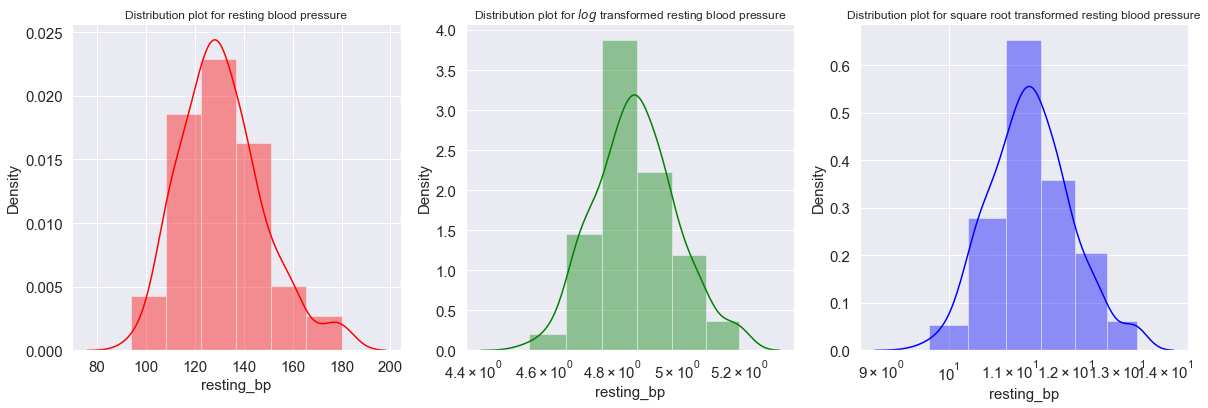

In [57]:
_, FD_bins = np.histogram(df_merged_data['ST_seg_pe_slope'], bins = "fd")
print(len(FD_bins))

# restrict the upper limit to 50
bin_fd = min(len(FD_bins)-1, 50)
print(bin_fd)

f= plt.figure(figsize=(20,6))
ax=f.add_subplot(131)
sns.distplot(df_merged_data['resting_bp'], bins = bin_fd, color ='red', ax=ax) 
ax.set_title('Distribution plot for resting blood pressure')

ax=f.add_subplot(132)
sns.distplot(np.log1p(df_merged_data['resting_bp']),  bins = bin_fd, color ='green',ax=ax) 
ax.set_title('Distribution plot for $log$ transformed resting blood pressure')
ax.set_xscale('log')

ax=f.add_subplot(133)
sns.distplot(np.sqrt(df_merged_data['resting_bp']),  bins = bin_fd, color ='blue',ax=ax) 
ax.set_title('Distribution plot for square root transformed resting blood pressure')
ax.set_xscale('log')

- Resting blood pressure seems to be normally distributed. No further transformation is required

### Apply different transformations - serum cholestrol in mg/dl

20
19


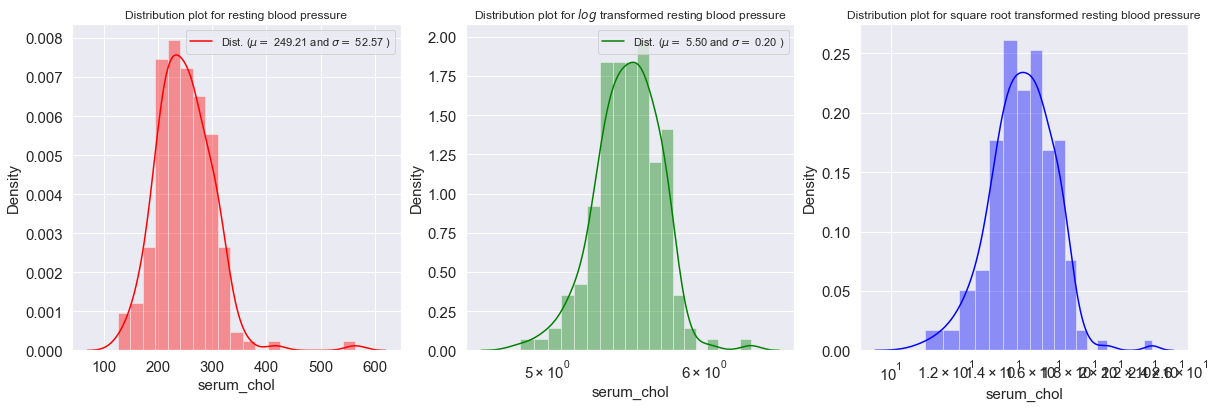

In [58]:
_, FD_bins = np.histogram(df_merged_data['serum_chol'], bins = "fd")
print(len(FD_bins))

# restrict the upper limit to 50
bin_fd = min(len(FD_bins)-1, 50)
print(bin_fd)

f= plt.figure(figsize=(20,6))
ax=f.add_subplot(131)
sns.distplot(df_merged_data['serum_chol'], bins = bin_fd, color ='red', ax=ax) 
ax.set_title('Distribution plot for resting blood pressure')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_merged_data['serum_chol'])

#Now plot the distribution
plt.legend(['Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], prop={'size': 11},
            loc='best')

#---------------------
### Log transformation
#---------------------
ax=f.add_subplot(132)
sns.distplot(np.log1p(df_merged_data['serum_chol']),  bins = bin_fd, color ='green',ax=ax) 
ax.set_title('Distribution plot for $log$ transformed resting blood pressure')
ax.set_xscale('log')

# Get the fitted parameters used by the function
(mu_, sigma_) = norm.fit(np.log1p(df_merged_data['serum_chol']))

#Now plot the distribution
plt.legend(['Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu_, sigma_)], prop={'size': 11},
            loc='best')

#-----------------------------
### Square root transformation
#-----------------------------
ax=f.add_subplot(133)
sns.distplot(np.sqrt(df_merged_data['serum_chol']),  bins = bin_fd, color ='blue',ax=ax) 
ax.set_title('Distribution plot for square root transformed resting blood pressure')
ax.set_xscale('log')

- Log transform will be applied to serum_chol

### Apply different transformations - oldpeak_ST_dep (stress test depression induced by exercise)

12
11


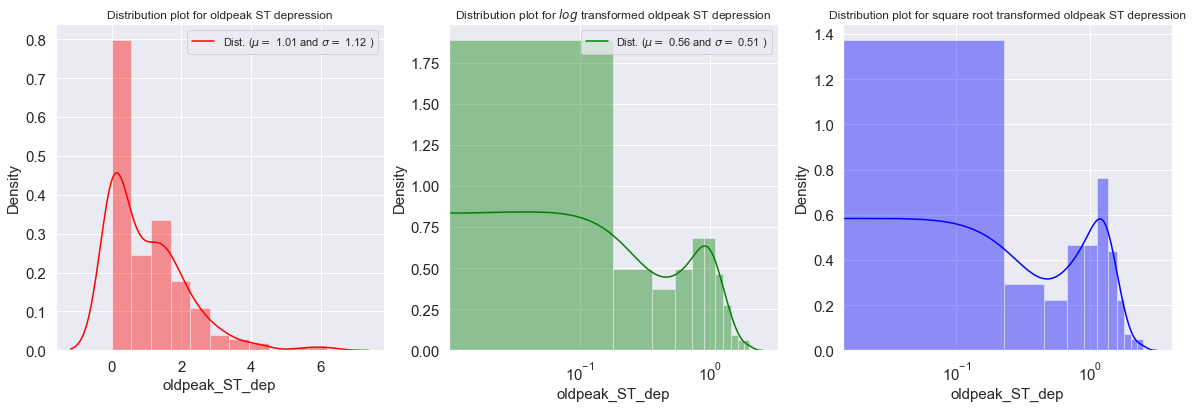

In [59]:
# determine the histogram bins using the Freedman Diaconis Estimator and restrict the upper limit to 50
_, FD_bins = np.histogram(df_merged_data['oldpeak_ST_dep'], bins = "fd")
print(len(FD_bins))
# bins=bin_nr - determine the histogram bins using the Freedman Diaconis Estimator and 
# restrict the upper limit to 50
bin_fd = min(len(FD_bins)-1, 50)
print(bin_fd)

f= plt.figure(figsize=(20,6))
ax=f.add_subplot(131)
sns.distplot(df_merged_data['oldpeak_ST_dep'], bins = bin_fd, color ='red', ax=ax) 
ax.set_title('Distribution plot for oldpeak ST depression')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_merged_data['oldpeak_ST_dep'])

#Now plot the distribution
plt.legend(['Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], prop={'size': 11},
            loc='best')

#---------------------
### Log transformation
#---------------------
ax=f.add_subplot(132)
sns.distplot(np.log1p(df_merged_data['oldpeak_ST_dep']),  bins = bin_fd, color ='green',ax=ax) 
ax.set_title('Distribution plot for $log$ transformed oldpeak ST depression')
ax.set_xscale('log')

# Get the fitted parameters used by the function
(mu_, sigma_) = norm.fit(np.log1p(df_merged_data['oldpeak_ST_dep']))

#Now plot the distribution
plt.legend(['Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu_, sigma_)], prop={'size': 11},
            loc='best')

#-----------------------------
### Square root transformation
#-----------------------------
ax=f.add_subplot(133)
sns.distplot(np.sqrt(df_merged_data['oldpeak_ST_dep']),  bins = bin_fd, color ='blue',ax=ax) 
ax.set_title('Distribution plot for square root transformed oldpeak ST depression')
ax.set_xscale('log')

- Log or square root transformation do not seem to be working as oldpeak ST depression has lot of zero values

Since log or square root transformation did not work I will apply log transformation and then standardization to check if normal distribution is achieved or not

In [60]:
# Let apply standardization to log transformed oldpeak ST depression and check the distribution
from sklearn.preprocessing import StandardScaler

df_merged_data['oldpeak_ST_dep_lt'] = np.log1p(df_merged_data['oldpeak_ST_dep'])
s_sc = StandardScaler()
col_to_scale = ['oldpeak_ST_dep_lt'] #['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df_merged_data['oldpeak_ST_dep_lt_scale'] = s_sc.fit_transform(df_merged_data[col_to_scale])

7
6


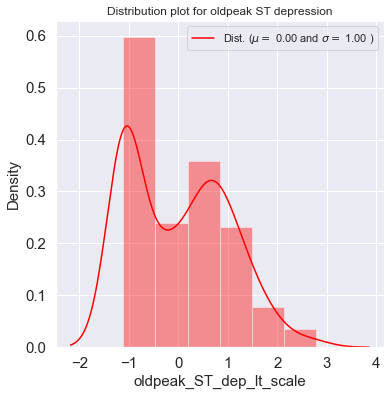

In [61]:
# determine the histogram bins using the Freedman Diaconis Estimator and restrict the upper limit to 50
_, FD_bins = np.histogram(df_merged_data['oldpeak_ST_dep_lt_scale'], bins = "fd")
print(len(FD_bins))
# bins=bin_nr - determine the histogram bins using the Freedman Diaconis Estimator and 
# restrict the upper limit to 50
bin_fd = min(len(FD_bins)-1, 50)
print(bin_fd)

f= plt.figure(figsize=(20,6))
ax=f.add_subplot(131)
sns.distplot(df_merged_data['oldpeak_ST_dep_lt_scale'], bins = bin_fd, color ='red', ax=ax) 
ax.set_title('Distribution plot for oldpeak ST depression')

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_merged_data['oldpeak_ST_dep_lt_scale'])

#Now plot the distribution
plt.legend(['Dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], prop={'size': 11},
            loc='best')
plt.show()

- After application of log transformation and standardization the distribution is bimodal

Convert oldpeak ST depression to bin and check the distribution

In [62]:
# Lets convert oldpeak ST depression to bin and check the distribution

_, FD_bins = np.histogram(df_merged_data['oldpeak_ST_dep'], bins = "fd")
print(len(FD_bins))

# restrict the upper limit to 50
bin_fd = min(len(FD_bins)-1, 50)
print(bin_fd)

# Dividing age into ranges
df_merged_data['oldpeak_ST_dep_bin'] = pd.cut(df_merged_data['oldpeak_ST_dep'], 11, precision=2)

12
11


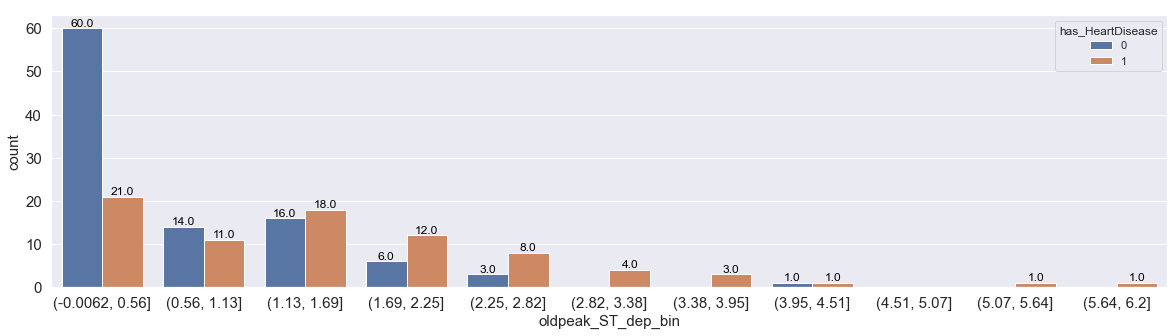

In [63]:
# Plotting count plot for age and income
fig = plt.figure(figsize=(20,5))
chart = sns.countplot(x="oldpeak_ST_dep_bin", hue="has_HeartDisease", data=df_merged_data)
for p in chart.patches:
    chart.annotate(f'\n{p.get_height()}', (p.get_x()+0.2, p.get_height()), ha='center', va='bottom', 
                   color='black', size=12)


- Decision - Distribution is still right skewed. So instead of any transformation I will perform frequency encoding to oldpeak ST depression

### Transformation - Log

In [64]:
df_merged_ohe_data['serum_chol_lt'] = np.log1p(df_merged_ohe_data['serum_chol']).copy()

### Frequency encoding

- Step 1 : Select a categorical variable you would like to transform
- Step 2 : Split the data into train and test
- Step 3 : From train dataset group by the categorical variable and obtain counts of each category
- Step 4 : Apply the count from train to both train and test dataset
- Step 5 : Join the count from the train back to the train dataset and to test dataset

I will apply frequency encoding on split data (train and test) 

In [65]:
features = df_merged_ohe_data.loc[ : , df_merged_ohe_data.columns != 'has_HeartDisease']
target = df_merged_ohe_data.has_HeartDisease

In [66]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [67]:
# train
ost_train = X_train.groupby(['oldpeak_ST_dep']).size().reset_index()
ost_train.columns = ['oldpeak_ST_dep', 'oldpeak_ST_dep_fe']
ost_train.head()

,oldpeak_ST_dep,oldpeak_ST_dep_fe
0,0.0,48
1,0.1,4
2,0.2,7
3,0.3,1
4,0.4,6


In [68]:
# test
ost_test = X_test.groupby(['oldpeak_ST_dep']).size().reset_index()
ost_test.columns = ['oldpeak_ST_dep', 'oldpeak_ST_dep_fe']
ost_test.head()

,oldpeak_ST_dep,oldpeak_ST_dep_fe
0,0.0,8
1,0.1,1
2,0.3,1
3,0.4,1
4,0.5,1


In [69]:
X_train = pd.merge(X_train, ost_train, on = 'oldpeak_ST_dep',how = 'left')
X_train.head()

,ST_seg_pe_slope,resting_bp,serum_chol,oldpeak_ST_dep,age,max_hr_ach,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,...,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,fbs_gt_120_1,resting_ekg_results_1,resting_ekg_results_2,sex_1,exer_angina_1,serum_chol_lt,oldpeak_ST_dep_fe
0,1,110,172,0.0,41,158,0,1,0,0,...,0,0,0,0,0,1,1,0,5.153292,48
1,1,126,282,0.0,35,156,0,1,0,0,...,0,0,0,0,0,1,1,1,5.645447,48
2,2,115,303,1.2,43,181,1,0,0,0,...,0,0,0,0,0,0,1,0,5.717028,6
3,2,150,225,1.0,65,114,0,1,0,0,...,0,0,1,0,0,1,0,0,5.420535,7
4,1,140,335,0.0,64,158,1,0,0,1,...,0,0,0,0,0,0,1,0,5.817111,48


In [70]:
X_train = X_train.drop(['oldpeak_ST_dep'],axis=1)

In [71]:
X_test = pd.merge(X_test, ost_test, on = 'oldpeak_ST_dep',how = 'left')
X_test.head()

,ST_seg_pe_slope,resting_bp,serum_chol,oldpeak_ST_dep,age,max_hr_ach,thal_normal,thal_reversible_defect,chest_pain_type_2,chest_pain_type_3,...,num_major_vessels_1,num_major_vessels_2,num_major_vessels_3,fbs_gt_120_1,resting_ekg_results_1,resting_ekg_results_2,sex_1,exer_angina_1,serum_chol_lt,oldpeak_ST_dep_fe
0,1,136,319,0.0,58,152,1,0,1,0,...,0,1,0,1,0,1,0,0,5.768321,8
1,1,110,265,0.0,71,130,1,0,0,1,...,1,0,0,1,0,1,0,0,5.583496,8
2,1,112,290,0.0,44,153,1,0,0,0,...,1,0,0,0,0,1,1,0,5.673323,8
3,2,145,282,2.8,60,142,0,1,0,0,...,0,1,0,0,0,1,1,1,5.645447,2
4,1,140,195,0.0,63,179,1,0,1,0,...,0,1,0,0,0,0,0,0,5.278115,8


In [72]:
X_test = X_test.drop(['oldpeak_ST_dep'],axis=1)

### Feature Standardization

In [73]:
X_test.columns 

Index(['ST_seg_pe_slope', 'resting_bp', 'serum_chol', 'age', 'max_hr_ach',
       'thal_normal', 'thal_reversible_defect', 'chest_pain_type_2',
       'chest_pain_type_3', 'chest_pain_type_4', 'num_major_vessels_1',
       'num_major_vessels_2', 'num_major_vessels_3', 'fbs_gt_120_1',
       'resting_ekg_results_1', 'resting_ekg_results_2', 'sex_1',
       'exer_angina_1', 'serum_chol_lt', 'oldpeak_ST_dep_fe'],
      dtype='object')

In [74]:
# make a copy of dataframe
X_tr_scaled_features = X_train.copy()
X_te_scaled_features = X_test.copy()

col_names = ['resting_bp', 'age', 'max_hr_ach', 'serum_chol_lt', 'oldpeak_ST_dep_fe']
tr_features = X_tr_scaled_features[col_names]
te_features = X_te_scaled_features[col_names]

# Use scaler of choice; here Standard scaler is used
scaler = StandardScaler().fit(tr_features.values)
tr_features_std = scaler.transform(tr_features.values)
te_features_std = scaler.transform(te_features.values)

# train
X_train[['resting_bp_std', 'age_std', 'max_hr_ach_std', 
         'serum_chol_lt_std', 'oldpeak_ST_dep_fe_std']] = tr_features_std

# test
X_test[['resting_bp_std', 'age_std', 'max_hr_ach_std', 
        'serum_chol_lt_std', 'oldpeak_ST_dep_fe_std']] = te_features_std

In [75]:
# drop following columns
X_train = X_train.drop(['resting_bp', 'serum_chol', 'serum_chol_lt', 'age', 'max_hr_ach','oldpeak_ST_dep_fe'], axis=1)
X_test = X_test.drop(['resting_bp', 'serum_chol', 'serum_chol_lt', 'age', 'max_hr_ach','oldpeak_ST_dep_fe'], axis=1)

Ensure the test data is encoded in the same manner as the training data. Use "align" command

In [76]:
X_train, X_test = X_train.align(X_test, join='left', axis=1)

#### Check the distribution after standardization

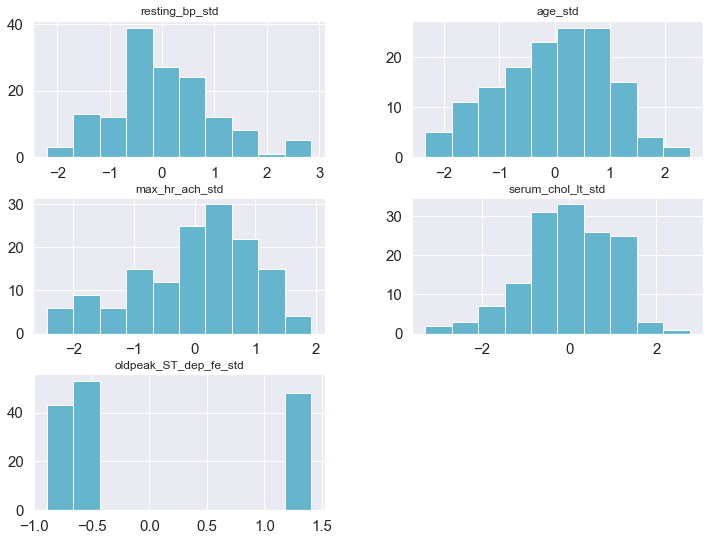

In [77]:
subset = X_train[['resting_bp_std', 'age_std', 'max_hr_ach_std', 'serum_chol_lt_std', 'oldpeak_ST_dep_fe_std']]
subset.hist(figsize=(12, 9), color = 'c');
#plt.show()

## <font color='orange'>9. Feature selection</font>

### 9.1 Backward Selection

I applied Backward feature selection technique. However other technique like filter method and forward feature selection technique caouls also be applied and compared 


Since the machine learning model is wrapped within the feature selection algorithm, we need to specify a model as one of the input parameters. I choose Logistic Regression for this classification problem and recall as the evaluation metrics. 

In [78]:
# sequential feature selection techniques are based on greedy search algorithms which applies 
# combinatorial methods for feature search

accuracy_df = pd.DataFrame({'feature count': [], 'recall': [],  'accuracy': [], 'score function': []})
# backward selection
for i in range(1, len(X_train.columns) + 1):
    #print(i)
    sfs1 = SFS(LogisticRegression(),
              k_features = i,
              forward = False,
              #floating = False, # remove features once they were included (or excluded), so that a larger number of feature subset combinations can be sampled.
              #verbose=2,
              scoring = 'recall',
              cv = 5) 
    
    # Fit the data to determine the k_features which give the
    # most optimal model performance
    
    # Perform Sequential Feature Backward Selector (SFBS) 
    X_train_selected = sfs1.fit(X_train, y_train) # fit_transform
        
    # Which features?
    feat_idx = list(X_train_selected.k_feature_idx_)
    feat_cols = list(X_train_selected.k_feature_names_) #k_feature_idx_
    

    reg = LogisticRegression()
    reg.fit(X_train.loc[:,feat_cols], y_train) # X_train_selected
    y_pred = reg.predict(X_test[list(X_train_selected.k_feature_names_)])
    #print('y_pred', y_pred)
    #print('y_test : ', y_test)
    sbs_recall = metrics.recall_score( y_pred, y_test)
    sbs_accuracy = metrics.accuracy_score(y_pred, y_test )
    
    new_record = {'feature count':round(i), 'recall': round(sbs_recall, 3), 
                  'accuracy':round(sbs_accuracy, 3), 'score function': 'backward elimination'}
    accuracy_df = accuracy_df.append(new_record, ignore_index = True)
    
print(accuracy_df)

    feature count  recall  accuracy        score function
0             1.0   0.882     0.806  backward elimination
1             2.0   0.882     0.806  backward elimination
2             3.0   0.882     0.806  backward elimination
3             4.0   1.000     0.778  backward elimination
4             5.0   0.882     0.806  backward elimination
5             6.0   0.929     0.778  backward elimination
6             7.0   0.929     0.778  backward elimination
7             8.0   0.938     0.833  backward elimination
8             9.0   0.938     0.833  backward elimination
9            10.0   0.933     0.806  backward elimination
10           11.0   0.938     0.833  backward elimination
11           12.0   0.938     0.833  backward elimination
12           13.0   0.938     0.833  backward elimination
13           14.0   0.938     0.833  backward elimination
14           15.0   0.941     0.861  backward elimination
15           16.0   0.938     0.833  backward elimination
16           1

### 9.1.1 Plot the above table

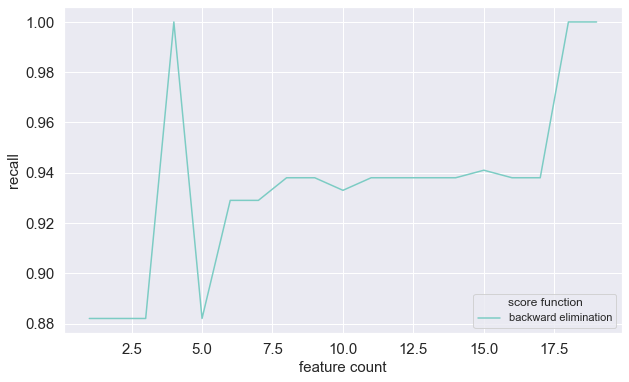

In [79]:
plt.figure(figsize = (10,6))
sns.lineplot(data = accuracy_df, x = 'feature count', y = 'recall', 
             hue = 'score function', palette = 'GnBu_r'); 

- Model performance is more or less stable with 8 to 9 features

### 9.1.2 Train and evaluate random forest only with selected features

In [84]:
# Build RF classifier with selected features

feat_8cols = X_train.columns[list(sfs1.k_feature_idx_)]

clf_rf = RandomForestClassifier(n_estimators=1000, max_depth=4) #n_estimators=1000,  max_depth=4, random_state=42,
clf_rf.fit(X_train.loc[:, feat_8cols], y_train)

y_train_pred = clf_rf.predict(X_train.loc[:, feat_8cols])
y_test_pred = clf_rf.predict(X_test.loc[:, feat_8cols])
predictions = [round(value) for value in y_test_pred]

print('Training accuracy score on selected features: %.3f' % accuracy_score(y_train, y_train_pred))
print('Testing accuracy score on selected features: %.3f' % accuracy_score(y_test, predictions))
print("="*50)
print('Training recall score on selected features: %.3f' % recall_score(y_train, y_train_pred))
print('Testing recall score on selected features: %.3f' % recall_score(y_test, predictions))
print("="*30)
print("Classification Report \n", classification_report(y_test,  predictions))

Training accuracy score on selected features: 0.875
Testing accuracy score on selected features: 0.861
Training recall score on selected features: 0.817
Testing recall score on selected features: 0.750
Classification Report 
               precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       1.00      0.75      0.86        20

    accuracy                           0.86        36
   macro avg       0.88      0.88      0.86        36
weighted avg       0.89      0.86      0.86        36



- With selected features test accuracy of random forest is at 83.3% while recall is at 70%

### 9.2 Multiple classifiers performance with all features

In [85]:
seed = 42
scoring = 'recall' #'accuracy' 

# Spot Check Algorithms
Classifiers = []
Classifiers.append(('LogReg', LogisticRegression(solver='liblinear')))
Classifiers.append(('RandomForestClassifier', RandomForestClassifier()))
Classifiers.append(('SGDclassifier', SGDClassifier()))
Classifiers.append(('KNearestNeighbors', KNeighborsClassifier()))
Classifiers.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
Classifiers.append(('XG Boost Classifier', XGBClassifier(#max_depth = 2,
                                                       disable_default_eval_metric = 1 ))) #eval_metric='logloss'
Classifiers.append(('SVM', SVC()))
Classifiers.append(('ABC', AdaBoostClassifier(n_estimators=24,
                                            learning_rate=1)))
Classifiers.append(('LGBM', LGBMClassifier()))


# Evaluate each model in turn
cols = ['model_name','mean_cv%','std_cv%']
model_perf = pd.DataFrame(columns = cols)
results = []
names = []
for name, model in Classifiers:
    kfold = model_selection.KFold(n_splits=10) # , random_state = seed, shuffle=True
    cv_results = model_selection.cross_val_score(model, X_train, y_train, 
                                                 cv = kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        
    model_perf = model_perf.append({'model_name': name, 
                                    'mean_cv%': round(cv_results.mean(),4)*100,
                                    'std_cv%': round(cv_results.std(),4)*100 },ignore_index=True)

In [86]:
print(tabulate(model_perf, headers='keys', tablefmt='pretty',showindex="never"))

+------------------------+-------------------+--------------------+
|       model_name       |     mean_cv%      |      std_cv%       |
+------------------------+-------------------+--------------------+
|         LogReg         |       73.17       |       18.23        |
| RandomForestClassifier |       70.49       |       24.32        |
|     SGDclassifier      |       77.58       |       25.15        |
|   KNearestNeighbors    | 63.07000000000001 |       21.67        |
| DecisionTreeClassifier |       67.89       | 19.689999999999998 |
|  XG Boost Classifier   | 75.92999999999999 | 16.439999999999998 |
|          SVM           |       69.48       | 22.650000000000002 |
|          ABC           |       71.26       |       22.33        |
|          LGBM          |       75.75       | 23.630000000000003 |
+------------------------+-------------------+--------------------+


### 9.3 Multiple classifiers performance with selected features

Lets try different type of classifiers with few features selected from backward feature selection approach

In [87]:
# Following features will be considered for fitting and evaluating multiple classifiers
feat_8cols = X_train.columns[list(sfs1.k_feature_idx_)]
feat_8cols

Index(['ST_seg_pe_slope', 'thal_normal', 'chest_pain_type_3',
       'chest_pain_type_4', 'num_major_vessels_1', 'num_major_vessels_3',
       'exer_angina_1', 'serum_chol_lt_std'],
      dtype='object')

In [88]:
seed = 42
scoring = 'recall' # scoring on 'recall' and not 'accuracy' 

# Spot Check Algorithms
Classifiers_List = []
Classifiers_List.append(('LogReg', LogisticRegression(solver='liblinear'))) # c= 100
Classifiers_List.append(('RandomForestClassifier', RandomForestClassifier(n_estimators=1000, max_depth=4)))
Classifiers_List.append(('SGDclassifier', SGDClassifier(loss="hinge", penalty="l2", max_iter=10)))
Classifiers_List.append(('KNearestNeighbors', KNeighborsClassifier(n_neighbors = 3))) #, weights = 'distance'
Classifiers_List.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
Classifiers_List.append(('XG Boost Classifier', XGBClassifier(max_depth = 2,
                                                               disable_default_eval_metric = 1)))
Classifiers_List.append(('SVM', SVC()))
Classifiers_List.append(('ABC', AdaBoostClassifier(n_estimators=24,
                                                    learning_rate=1)))
Classifiers_List.append(('LGBM', LGBMClassifier(#boosting_type = 'rf'
                                                 objective='binary'
                                                 ,learning_rate = 0.05
                                                 ,max_depth = 8,num_leaves=20
                                                 )))

# Evaluate each model in turn
cols = ['model_name','mean_cv%','std_cv%']
model_perf = pd.DataFrame(columns = cols)
results = []
names = []
for name, model in Classifiers_List:
    kfold = model_selection.KFold(n_splits=10) # , random_state = seed, shuffle=True
    cv_results = model_selection.cross_val_score(model, X_train.loc[:, feat_8cols], y_train, 
                                                 cv = kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    model_perf = model_perf.append({'model_name': name, 
                                    'mean_cv%': round(cv_results.mean(),4)*100,
                                    'std_cv%': round(cv_results.std(),4)*100 },ignore_index=True)

In [89]:
print(tabulate(model_perf, headers='keys', tablefmt='pretty',showindex="never"))

+------------------------+-------------------+---------+
|       model_name       |     mean_cv%      | std_cv% |
+------------------------+-------------------+---------+
|         LogReg         |       83.5        |  21.46  |
| RandomForestClassifier |       80.17       |  21.22  |
|     SGDclassifier      |       70.57       |  21.37  |
|   KNearestNeighbors    | 69.32000000000001 |  21.04  |
| DecisionTreeClassifier |       70.81       |  17.25  |
|  XG Boost Classifier   |       76.82       |  22.28  |
|          SVM           |       78.92       |  20.54  |
|          ABC           |       83.26       |  22.38  |
|          LGBM          |       75.25       |  22.1   |
+------------------------+-------------------+---------+


- With selected features following classifers improved
    - LogReg
    - KNearestNeighbors
    - XG Boost Classifier
    - SVM
    - Ada Boost Classifier (ABC)

Among all the classifiers, 
- on selected features, <font color='yellow'>Logistic Regression</font> performed the best followed by <font color='orange'>Ada Boost Classifier</font>, <font color='orange'>Random Forest Classifier</font> and <font color='orange'>SVM</font>
- on all features, <font color='yellow'>XG Boost Classifier</font> performed the best followed by <font color='orange'>Random Forest Classifier</font>

However classifier on selected features performed better then on all features

## <font color='orange'>10. Classifers based on tuned hyperparameters</font>

### 10.1 Hyper parameter tuning using GridsearchCV - Logistic regression

In [90]:
 # define models and parameters
lr_clf = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear','saga']
penalty = ['l2','l1']
c_values = [100, 10, 1.0, 0.1, 0.01]

# define grid search
grid = dict(solver = solvers, penalty = penalty, C = c_values)
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3) #, random_state = 1
lr_grid_search = GridSearchCV(estimator = lr_clf, param_grid = grid, n_jobs =-1, 
                              cv = cv, scoring = 'recall',error_score=0)
lr_grid_result = lr_grid_search.fit(X_train.loc[:, feat_8cols], y_train)

In [91]:
# summarize results
print("Best: %f using %s" % (lr_grid_result.best_score_, lr_grid_result.best_params_))
print("="*70)
means = lr_grid_result.cv_results_['mean_test_score']
stds = lr_grid_result.cv_results_['std_test_score']
params = lr_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.805556 using {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.755556 (0.181217) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.755556 (0.181217) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.755556 (0.181217) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.755556 (0.181217) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.755556 (0.181217) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.755556 (0.181217) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.761111 (0.180961) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.761111 (0.180961) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.772222 (0.169331) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.761111 (0.180961) with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 10,

### 10.1.1 LR model with optimum hyper parameters

In [92]:
lr_clf_best_param = LogisticRegression(C = 1.0, penalty = 'l2', solver = 'liblinear')

# model training or fitting - calculate the best weights using available observations
# To get the best weights, you usually maximize the log-likelihood function (LLF) 
# for all observations 𝑖 = 1, …, 𝑛. This method is called the maximum likelihood estimation
# Logistic regression determines the weights 𝑏₀, 𝑏₁, and 𝑏₂ that maximize the LLF
lr_clf_best_param = lr_clf_best_param.fit(X_train.loc[:, feat_8cols], y_train)

# Evaluate
y_tr_pred_lr = lr_clf_best_param.predict(X_train.loc[:, feat_8cols])
y_te_pred_lr = lr_clf_best_param.predict(X_test.loc[:, feat_8cols])

train_acc_score = round(accuracy_score(y_train, y_tr_pred_lr),4)*100
test_acc_score = round(accuracy_score(y_test, y_te_pred_lr),4)*100
train_recall_score = round(recall_score(y_train, y_tr_pred_lr),4)*100
test_recall_score = round(recall_score(y_test, y_te_pred_lr),4)*100

results_df = pd.DataFrame(data=[["Tuned Logistic Regression", train_acc_score, 
                                                              test_acc_score, 
                                                              train_recall_score, 
                                                              test_recall_score]], 
                          columns=['Model', 'Training Accuracy %', 'Testing Accuracy %',
                                            'Training Recall %', 'Testing Recall %'])
print("Classification Report \n", classification_report(y_test,  y_te_pred_lr))

Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.94      0.75      0.83        20

    accuracy                           0.83        36
   macro avg       0.84      0.84      0.83        36
weighted avg       0.85      0.83      0.83        36



In [93]:
confusion_matrix(y_test, y_te_pred_lr) 

array([[15,  1],
       [ 5, 15]], dtype=int64)

### 10.1.2 Predict probability on both train and test data

In [94]:
# The first column is the probability of the predicted output being zero, that is 1 - 𝑝(𝑥). 
# The second column is the probability that the output is one, or 𝑝(𝑥).

# Scikit-learn uses LibSVM internally, and this in turn uses Platt scaling, 
# to calibrate the SVM to produce probabilities in addition to class predictions
# the hyperplane predictions and the proba calibration can disagree, especially 
# if you only have few samples in your dataset
y_train_predict_proba = lr_clf_best_param.predict_proba(X_train.loc[:, feat_8cols])[:,1]
y_test_predict_proba = lr_clf_best_param.predict_proba(X_test.loc[:, feat_8cols])[:,1]

# calculate roc curves
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_predict_proba)   # Train

test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_predict_proba)       # Test

### 10.1.3 Plot the train and test AUC

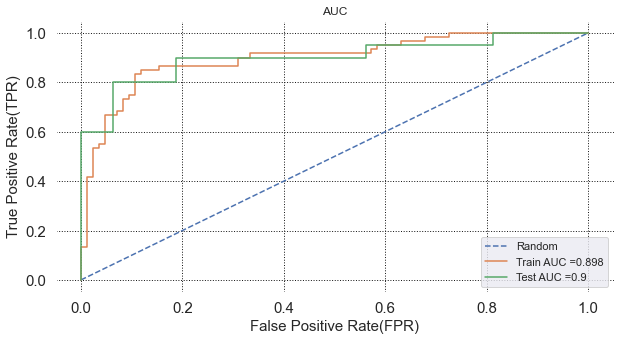

In [95]:
plt.figure(figsize=(10,5))
ax = plt.subplot()

auc_lr_train=auc(train_fpr, train_tpr)
auc_lr_test=auc(test_fpr, test_tpr)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random')
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc_lr_train,3)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(round(auc_lr_test,3)))

plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

### 10.1.4 Confusion matrix for train and test

The max value of tpr*(1 - fpr) is 0.749 for threshold 0.512
The max value of tpr*(1 - fpr) is 0.75 for threshold 0.402


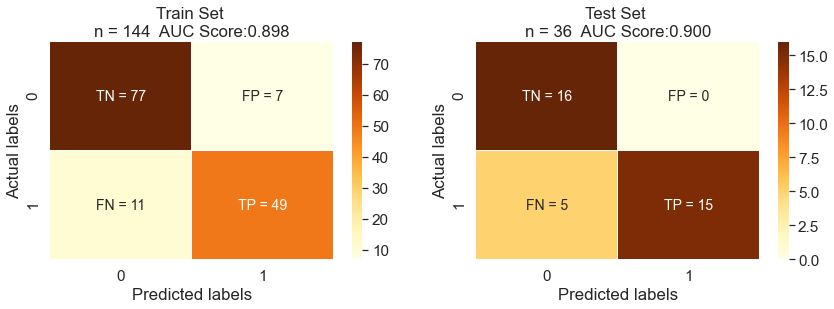

In [96]:
# train and test thresholds 
train_threshold = best_threshold(tr_thresholds, train_fpr, train_tpr)
test_threshold = best_threshold(te_thresholds, test_fpr, test_tpr)

y_tr_pred = predict_with_best_t(y_train_pred, train_threshold)
y_te_pred = predict_with_best_t(y_test_pred, test_threshold)

sns.set(font_scale=1.4)                    
cm_train = confusion_matrix(y_train, y_tr_pred)
cm_test = confusion_matrix(y_test, y_te_pred)
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1,2, figsize=(14, 4))
train_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(), 
                           cm_train.flatten())])).reshape(2, 2)
test_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(),
                          cm_test.flatten())])).reshape(2, 2)

sns.heatmap(cm_train, linewidths=.25, annot = train_label, annot_kws={"size": 14}, fmt = '', ax = ax[0]
            , cmap = 'YlOrBr') # YlGnBu
sns.heatmap(cm_test, linewidths=.25, annot = test_label, annot_kws={"size": 14}, fmt = '', ax = ax[1]
            , cmap = 'YlOrBr')

ax[0].set_xlabel('Predicted labels'); ax[0].set_ylabel('Actual labels')
ax[1].set_xlabel('Predicted labels'); ax[1].set_ylabel('Actual labels')
ax[0].set_title('Train Set \nn = {0}  AUC Score:{1:.3f}'.format(X_train.loc[:, feat_8cols].shape[0], round(auc_lr_train,3)))
ax[1].set_title('Test Set \nn = {0}  AUC Score:{1:.3f}'.format(X_test.loc[:, feat_8cols].shape[0], round(auc_lr_test,3)))
plt.show()

#========================================================================================#

### 10.2 Hyper parameter tuning - Adaboost

In [97]:
# define the model with default hyperparameters
clf_abc = AdaBoostClassifier(base_estimator = LogisticRegression())

# define the grid of values to search
grid = dict()
grid['n_estimators'] = [1, 10, 50, 100, 500,1000]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3) #, random_state=1

# define the grid search procedure
abc_grid_search = GridSearchCV(estimator = clf_abc, param_grid = grid, 
                               n_jobs = -1, cv = cv, scoring = 'recall') #accuracy

# execute the grid search
abc_grid_result = abc_grid_search.fit(X_train.loc[:, feat_8cols], y_train)

In [98]:
# summarize the best score and configuration
print("Best: %f using %s" % (abc_grid_result.best_score_, abc_grid_result.best_params_))

# summarize all scores that were evaluated
means = abc_grid_result.cv_results_['mean_test_score']
stds = abc_grid_result.cv_results_['std_test_score']
params = abc_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.777778 using {'learning_rate': 0.1, 'n_estimators': 500}
0.033333 (0.066667) with: {'learning_rate': 0.0001, 'n_estimators': 1}
0.033333 (0.066667) with: {'learning_rate': 0.0001, 'n_estimators': 10}
0.033333 (0.066667) with: {'learning_rate': 0.0001, 'n_estimators': 50}
0.033333 (0.066667) with: {'learning_rate': 0.0001, 'n_estimators': 100}
0.038889 (0.070492) with: {'learning_rate': 0.0001, 'n_estimators': 500}
0.038889 (0.070492) with: {'learning_rate': 0.0001, 'n_estimators': 1000}
0.033333 (0.066667) with: {'learning_rate': 0.001, 'n_estimators': 1}
0.033333 (0.066667) with: {'learning_rate': 0.001, 'n_estimators': 10}
0.038889 (0.070492) with: {'learning_rate': 0.001, 'n_estimators': 50}
0.038889 (0.070492) with: {'learning_rate': 0.001, 'n_estimators': 100}
0.133333 (0.131937) with: {'learning_rate': 0.001, 'n_estimators': 500}
0.266667 (0.190516) with: {'learning_rate': 0.001, 'n_estimators': 1000}
0.033333 (0.066667) with: {'learning_rate': 0.01, 'n_estimators': 1}
0.

- we can see that a configuration with 10 trees and a learning rate of 0.1 performed the best with a recall classification of about 77.77 percent.
- we can see that with a base estimator as a LogisticRegression, a configuration with 1000 estimator and a learning rate of 0.1 performed the best with a recall classification of about 80 percent.

### 10.2.1 Ada Boost classification model with optimum hyper parameters

In [99]:
abc_clf_best_param = AdaBoostClassifier(base_estimator = LogisticRegression(),
                                        learning_rate = 0.1, n_estimators = 500)
abc_clf_best_param.fit(X_train.loc[:, feat_8cols], y_train)

# Evaluate
y_tr_pred_abc = abc_clf_best_param.predict(X_train.loc[:, feat_8cols])
y_te_pred_abc = abc_clf_best_param.predict(X_test.loc[:, feat_8cols])

abc_train_acc_score = round(accuracy_score(y_train, y_tr_pred_abc),4)*100
abc_test_acc_score = round(accuracy_score(y_test, y_te_pred_abc),4)*100
abc_train_recall_score = round(recall_score(y_train, y_tr_pred_abc),4)*100
abc_test_recall_score = round(recall_score(y_test, y_te_pred_abc),4)*100

# results_df.loc[len(results_df.index)]
data = pd.DataFrame(data=[["Tuned Ada Boost Classifier", 
                              abc_train_acc_score, 
                              abc_test_acc_score, 
                              abc_train_recall_score, 
                              abc_test_recall_score]],
                    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %',
                            'Training Recall %', 'Testing Recall %'])
# Add new row 
results_df = pd.concat([results_df, data], axis=0)

print("Classification Report \n", classification_report(y_test,  y_te_pred_abc))

Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.94      0.75      0.83        20

    accuracy                           0.83        36
   macro avg       0.84      0.84      0.83        36
weighted avg       0.85      0.83      0.83        36



In [100]:
results_df

,Model,Training Accuracy %,Testing Accuracy %,Training Recall %,Testing Recall %
0,Tuned Logistic Regression,86.81,83.33,85.00,75.0
0,Tuned Ada Boost Classifier,86.11,83.33,81.67,75.0


### 10.3 Hyper parameter tuning - SVM

In [101]:
# define the model with default hyperparameters
clf_svm = SVC()

# define search space
params = dict()

# C - Regularization parameter. The strength of the regularization is inversely proportional to C
params['C'] = (1e-6, 100.0, 'log-uniform')

# Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’
params['gamma'] = (1e-6, 100.0, 'log-uniform')

# Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels
params['degree'] = (1, 5)

# default = ‘rbf’
params['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3) #, random_state=1

# define the grid search procedure
svm_grid_search = GridSearchCV(estimator = clf_svm, param_grid = params, 
                               n_jobs = -1, cv = cv, scoring = 'recall') #accuracy

# execute the grid search
svm_grid_result = svm_grid_search.fit(X_train.loc[:, feat_8cols], y_train)

In [102]:
# summarize the best score and configuration
print("Best: %f using %s" % (svm_grid_result.best_score_, svm_grid_result.best_params_))

# summarize all scores that were evaluated
means = svm_grid_result.cv_results_['mean_test_score']
stds = svm_grid_result.cv_results_['std_test_score']
params = svm_grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.722222 using {'C': 100.0, 'degree': 1, 'gamma': 1e-06, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 1e-06, 'degree': 1, 'gamma': 1e-06, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 1e-06, 'degree': 1, 'gamma': 1e-06, 'kernel': 'poly'}
0.000000 (0.000000) with: {'C': 1e-06, 'degree': 1, 'gamma': 1e-06, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 1e-06, 'degree': 1, 'gamma': 1e-06, 'kernel': 'sigmoid'}
0.000000 (0.000000) with: {'C': 1e-06, 'degree': 1, 'gamma': 100.0, 'kernel': 'linear'}
0.000000 (0.000000) with: {'C': 1e-06, 'degree': 1, 'gamma': 100.0, 'kernel': 'poly'}
0.000000 (0.000000) with: {'C': 1e-06, 'degree': 1, 'gamma': 100.0, 'kernel': 'rbf'}
0.000000 (0.000000) with: {'C': 1e-06, 'degree': 1, 'gamma': 100.0, 'kernel': 'sigmoid'}
nan (nan) with: {'C': 1e-06, 'degree': 1, 'gamma': 'log-uniform', 'kernel': 'linear'}
nan (nan) with: {'C': 1e-06, 'degree': 1, 'gamma': 'log-uniform', 'kernel': 'poly'}
nan (nan) with: {'C': 1e-06, 'degree': 1, 'gamma': 

### 10.3.1 SVM with optimum hyper parameters to predict the class labels

In [103]:
best_params = svm_grid_result.best_params_
svm_clf_best_param = SVC(**best_params) # SVC(C = 100.0, degree = 1, gamma = 1e-06, kernel = 'linear')
svm_clf_best_param.fit(X_train.loc[:, feat_8cols], y_train)

# Evaluate
y_tr_pred_svm = svm_clf_best_param.predict(X_train.loc[:, feat_8cols])
y_te_pred_svm = svm_clf_best_param.predict(X_test.loc[:, feat_8cols])

svm_train_acc_score = round(accuracy_score(y_train, y_tr_pred_svm),4)*100
svm_test_acc_score = round(accuracy_score(y_test, y_te_pred_svm),4)*100
svm_train_recall_score = round(recall_score(y_train, y_tr_pred_svm),4)*100
svm_test_recall_score = round(recall_score(y_test, y_te_pred_svm),4)*100

data = pd.DataFrame(data=[["Tuned SVM Classifier", 
                              svm_train_acc_score, 
                              svm_test_acc_score, 
                              svm_train_recall_score, 
                              svm_test_recall_score]],
                    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %',
                            'Training Recall %', 'Testing Recall %'])
# Add new row 
results_df = pd.concat([results_df, data], axis=0)

print("Classification Report \n", classification_report(y_test,  y_te_pred_svm))

Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.94      0.75      0.83        20

    accuracy                           0.83        36
   macro avg       0.84      0.84      0.83        36
weighted avg       0.85      0.83      0.83        36



In [104]:
results_df

,Model,Training Accuracy %,Testing Accuracy %,Training Recall %,Testing Recall %
0,Tuned Logistic Regression,86.81,83.33,85.00,75.0
0,Tuned Ada Boost Classifier,86.11,83.33,81.67,75.0
0,Tuned SVM Classifier,86.11,83.33,81.67,75.0


### 10.3.2 SVM with optimum parameter to predict probability of class

SVMs don’t output probabilities natively, but probability calibration methods can be used to convert the output to class probabilities. Various methods exist, including Platt scaling (particularly suitable for SVMs) and isotonic regression.

In [105]:
model_svm = SVC(C = 100.0, degree = 1, gamma= 100.0, kernel= 'poly', probability=False) # Initialize the SVM
model_svm.fit(X_train.loc[:, feat_8cols], y_train) # Train the SVM

# keep probabilities for the positive outcome only

tr_svm_results = model_svm.decision_function(X_train.loc[:, feat_8cols])
te_svm_results = model_svm.decision_function(X_test.loc[:, feat_8cols])

# gets a dictionary of {'class_name': probability}
prob_per_class_tr_dict = dict(zip(model_svm.classes_, tr_svm_results))
prob_per_class_te_dict = dict(zip(model_svm.classes_, te_svm_results))

tr_results_ordered_by_prob = map(lambda x: x[0], sorted(zip(model_svm.classes_, tr_svm_results), key=lambda x: x[1], reverse=True))
te_results_ordered_by_prob = map(lambda x: x[0], sorted(zip(model_svm.classes_, te_svm_results), key=lambda x: x[1], reverse=True))

In [106]:
# The first column is the probability of the predicted output being zero, that is 1 - 𝑝(𝑥). 
# The second column is the probability that the output is one, or 𝑝(𝑥).

# calculate roc curves
train_fpr, train_tpr, tr_svm_thresholds = roc_curve(y_train, tr_svm_results)   # Train
test_fpr, test_tpr, te_svm_thresholds = roc_curve(y_test, te_svm_results)      # Test

### 10.3.3 Plot the train and test AUC

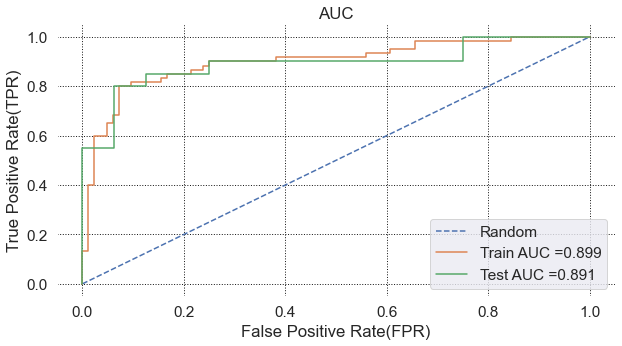

In [107]:
plt.figure(figsize=(10,5))
ax = plt.subplot()

auc_svm_train=auc(train_fpr, train_tpr)
auc_svm_test=auc(test_fpr, test_tpr)

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='Random')
ax.plot(train_fpr, train_tpr, label="Train AUC ="+str(round(auc_svm_train,3)))
ax.plot(test_fpr, test_tpr, label="Test AUC ="+str(round(auc_svm_test,3)))
# plt.scatter(test_fpr[ix], test_tpr[ix], marker='o', color='black', label='Best')

plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(b=True, which='major', color='k', linestyle=':')
ax.set_facecolor("white")
plt.show()

### 10.3.4 Confusion matrix for train and test

The max value of tpr*(1 - fpr) is 0.743 for threshold 0.218
The max value of tpr*(1 - fpr) is 0.75 for threshold -0.04


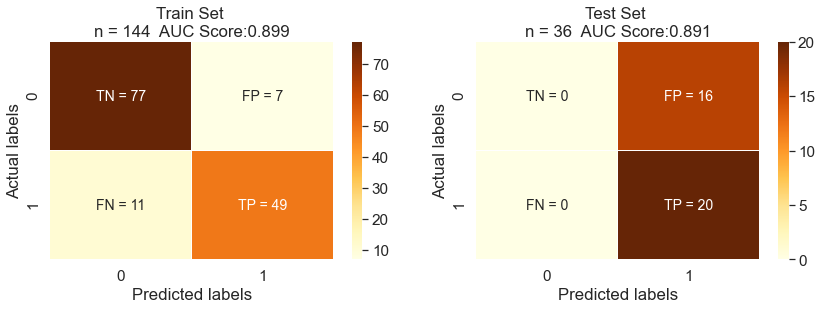

In [108]:
# train and test thresholds 
train_svm_threshold = best_threshold(tr_svm_thresholds, train_fpr, train_tpr)
test_svm_threshold = best_threshold(te_svm_thresholds, test_fpr, test_tpr)

y_tr_svm_pred = predict_with_best_t(y_train_pred, train_svm_threshold)
y_te_svm_pred = predict_with_best_t(y_test_pred, test_svm_threshold)

sns.set(font_scale=1.4)                    
cm_svm_train = confusion_matrix(y_train, y_tr_svm_pred)
cm_svm_test = confusion_matrix(y_test, y_te_svm_pred)
key = (np.asarray([['TN','FP'], ['FN', 'TP']]))

fig, ax = plt.subplots(1,2, figsize=(14, 4))
train_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(), 
                           cm_svm_train.flatten())])).reshape(2, 2)
test_label = (np.asarray(["{0} = {1}" .format(key, value) for key, value in zip(key.flatten(),
                          cm_svm_test.flatten())])).reshape(2, 2)

sns.heatmap(cm_svm_train, linewidths=.25, annot = train_label, annot_kws={"size": 14}, fmt = '', ax = ax[0]
            , cmap = 'YlOrBr') # YlGnBu
sns.heatmap(cm_svm_test, linewidths=.25, annot = test_label, annot_kws={"size": 14}, fmt = '', ax = ax[1]
            , cmap = 'YlOrBr')

ax[0].set_xlabel('Predicted labels'); ax[0].set_ylabel('Actual labels')
ax[1].set_xlabel('Predicted labels'); ax[1].set_ylabel('Actual labels')
ax[0].set_title('Train Set \nn = {0}  AUC Score:{1:.3f}'.format(X_train.loc[:, feat_8cols].shape[0], round(auc_svm_train,3)))
ax[1].set_title('Test Set \nn = {0}  AUC Score:{1:.3f}'.format(X_test.loc[:, feat_8cols].shape[0], round(auc_svm_test,3)))
plt.show()

#========================================================================================#

### 10.4 Hyper parameter tuning - Random Forest

#### 10.4.1 Random Search CV

The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation

In [109]:
# number of trees in the foreset
n_estimators = [int(x) for x in np.linspace(start=100, stop=500, num=20)]

# max number of features considered for splitting a node
max_features = ['auto', 'sqrt']

# max number of levels in each decision tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# min number of data points placed in a node before the node is split
min_samples_split = [2, 5, 10]

# min number of data points allowed in a leaf node
min_samples_leaf = [1, 2, 4]

# method for sampling data points (with or without replacement)
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 
               'bootstrap': bootstrap}

#print(params_grid)

rf_clf = RandomForestClassifier() #random_state=42

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5) #, random_state=1

# define the grid search procedure
# GridSearchCV
rf_random_search = RandomizedSearchCV(estimator = rf_clf, param_distributions = params_grid, 
                                      n_iter = 100, cv=cv, n_jobs=-1, scoring='recall', verbose=2) 

# execute the grid search
rf_random_result = rf_random_search.fit(X_train.loc[:, feat_8cols], y_train)
best_params = rf_random_result.best_params_
print(f"Best parameters: {best_params}")

Fitting 25 folds for each of 100 candidates, totalling 2500 fits
Best parameters: {'n_estimators': 289, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


In [110]:
# summarize the best score and configuration
print("Best: %f using %s" % (rf_random_result.best_score_, rf_random_result.best_params_))

# summarize all scores that were evaluated
means = rf_random_result.cv_results_['mean_test_score']
stds = rf_random_result.cv_results_['std_test_score']
params = rf_random_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.773333 using {'n_estimators': 289, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True}


#### 10.4.2 Grid Search CV

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define.

In [111]:
# Now we know the best paramters so we can set parameters for Grid Search

# number of trees in the foreset
n_estimators = [100,200,300,800]

# max number of features considered for splitting a node
max_features = ['sqrt']

# max number of levels in each decision tree
max_depth = [20,30,50,60]
max_depth.append(None)

# min number of data points placed in a node before the node is split
min_samples_split = [8, 10, 12]

# min number of data points allowed in a leaf node
min_samples_leaf = [4, 5, 6, 7]

# method for sampling data points (with or without replacement)
bootstrap = [False]

params_grid = {'n_estimators': n_estimators, 
               'max_features': max_features,
               'max_depth': max_depth, 
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 
               'bootstrap': bootstrap}

rf_clf = RandomForestClassifier() #random_state=42

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5) #, random_state=1

# define the grid search procedure
# GridSearchCV
rf_grid_search = GridSearchCV(estimator = rf_clf, param_grid = params_grid, 
                              cv=cv, n_jobs=-1, scoring='recall', verbose=2) 

# execute the grid search
rf_grid_result = rf_grid_search.fit(X_train.loc[:, feat_8cols], y_train)
best_params = rf_grid_result.best_params_
print(f"Best parameters: {best_params}")

Fitting 25 folds for each of 240 candidates, totalling 6000 fits
Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 100}


### 10.4.3 Random Forest performance with optimum parameters

In [112]:
rf_clf_best_param = RandomForestClassifier(**best_params)
rf_clf_best_param.fit(X_train.loc[:, feat_8cols], y_train)

# Evaluate
y_tr_pred_rf = rf_clf_best_param.predict(X_train.loc[:, feat_8cols])
y_te_pred_rf = rf_clf_best_param.predict(X_test.loc[:, feat_8cols])

rf_train_acc_score = round(accuracy_score(y_train, y_tr_pred_rf),4)*100
rf_test_acc_score = round(accuracy_score(y_test, y_te_pred_rf),4)*100
rf_train_recall_score = round(recall_score(y_train, y_tr_pred_rf),4)*100
rf_test_recall_score = round(recall_score(y_test, y_te_pred_rf),4)*100

# results_df.loc[len(results_df.index)]
data = pd.DataFrame(data=[["Tuned Random Forest Classifier", 
                              rf_train_acc_score, 
                              rf_test_acc_score, 
                              rf_train_recall_score, 
                              rf_test_recall_score]],
                    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %',
                            'Training Recall %', 'Testing Recall %'])
# Add new row 
results_df = pd.concat([results_df, data], axis=0)

print("Classification Report \n", classification_report(y_test,  y_te_pred_rf))

Classification Report 
               precision    recall  f1-score   support

           0       0.70      1.00      0.82        16
           1       1.00      0.65      0.79        20

    accuracy                           0.81        36
   macro avg       0.85      0.82      0.80        36
weighted avg       0.86      0.81      0.80        36



In [113]:
results_df

,Model,Training Accuracy %,Testing Accuracy %,Training Recall %,Testing Recall %
0,Tuned Logistic Regression,86.81,83.33,85.00,75.0
0,Tuned Ada Boost Classifier,86.11,83.33,81.67,75.0
0,Tuned SVM Classifier,86.11,83.33,81.67,75.0
0,Tuned Random Forest Classifier,87.50,80.56,80.00,65.0


#========================================================================================#

### 10.5 Model Stacking with optimum hyperparameters

In [114]:
# Stacking regressor function to ensemble AdaBoost and SVC
def get_stacking():
    level0 = [('AdaBoost Classifier', AdaBoostClassifier(learning_rate = 0.1, n_estimators = 500)),
              ('SV Classifier', SVC(C = 100.0, degree = 1, gamma = 1e-06, kernel = 'linear'))]
    
    level1 = LogisticRegression(C = 1.0, penalty = 'l2', solver = 'liblinear')
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [115]:
# Stack Model 
model = get_stacking() # <-- Performed Best

# Model Training
stackedModel = model.fit(X_train.loc[:, feat_8cols], y_train)

stackedModel_tr_pred = stackedModel.predict(X_train.loc[:, feat_8cols])
stackedModel_te_pred = stackedModel.predict(X_test.loc[:, feat_8cols])

# accuracy score
stackedModel_tr_acc_score = round(accuracy_score(y_train, stackedModel_tr_pred),4)*100
stackedModel_te_acc_score = round(accuracy_score(y_test, stackedModel_te_pred),4)*100

# recall score
stackedModel_tr_recall_score = round(recall_score(y_train, stackedModel_tr_pred),4)*100
stackedModel_te_recall_score = round(recall_score(y_test, stackedModel_te_pred),4)*100

data = pd.DataFrame(data=[["Stacked Classifier", 
                              stackedModel_tr_acc_score, 
                              stackedModel_te_acc_score, 
                              stackedModel_tr_recall_score, 
                              stackedModel_te_recall_score]],
                    columns=['Model', 'Training Accuracy %', 'Testing Accuracy %',
                            'Training Recall %', 'Testing Recall %'])
# Add new row 
results_df = pd.concat([results_df, data], axis=0)

print("Classification Report \n", classification_report(y_test,  stackedModel_te_pred))

Classification Report 
               precision    recall  f1-score   support

           0       0.75      0.94      0.83        16
           1       0.94      0.75      0.83        20

    accuracy                           0.83        36
   macro avg       0.84      0.84      0.83        36
weighted avg       0.85      0.83      0.83        36



In [116]:
results_df

,Model,Training Accuracy %,Testing Accuracy %,Training Recall %,Testing Recall %
0,Tuned Logistic Regression,86.81,83.33,85.00,75.0
0,Tuned Ada Boost Classifier,86.11,83.33,81.67,75.0
0,Tuned SVM Classifier,86.11,83.33,81.67,75.0
0,Tuned Random Forest Classifier,87.50,80.56,80.00,65.0
0,Stacked Classifier,86.81,83.33,81.67,75.0


### 11 Summary - Classifers performance 

In [117]:
print(tabulate(results_df, headers='keys', tablefmt='pretty',showindex="never"))

+--------------------------------+---------------------+--------------------+-------------------+------------------+
|             Model              | Training Accuracy % | Testing Accuracy % | Training Recall % | Testing Recall % |
+--------------------------------+---------------------+--------------------+-------------------+------------------+
|   Tuned Logistic Regression    |        86.81        |       83.33        |       85.0        |       75.0       |
|   Tuned Ada Boost Classifier   |        86.11        |       83.33        |       81.67       |       75.0       |
|      Tuned SVM Classifier      |        86.11        |       83.33        |       81.67       |       75.0       |
| Tuned Random Forest Classifier |        87.5         |       80.56        |       80.0        |       65.0       |
|       Stacked Classifier       |        86.81        |       83.33        |       81.67       |       75.0       |
+--------------------------------+---------------------+--------

Among all the classifers I tried, tuned SVM classifier performed the best. Reason being
- the model overfitting is less compared to other models 
- accuracy on unseen data = 83.33% and test recall = 75% 

In [118]:
# Using tuned SVM the predicted probability of train and test dataset
final_svm_predicted_prob = np.append(tr_svm_results, te_svm_results)
print(final_svm_predicted_prob.shape)

(180,)


In [119]:
print("Finished at ", dt.datetime.now())
overall_end_time = dt.datetime.now()
print("Total time taken for overall execution - ", (overall_end_time - start_time0))

Finished at  2021-08-09 09:26:00.476806
Total time taken for overall execution -  0:13:44.860563
